In [1]:
from pandas import DataFrame, Series, read_csv
import pandas as pd
from dslabs_functions import ts_aggregation_by

file_tag = "covid"
target = "deaths"
index="date"
data: DataFrame = read_csv(
    f"data/{file_tag}/forecast_covid_single.csv",
    index_col="date",
    sep=",",
    decimal=".",
    parse_dates=True,
)
series: Series = data[target]

print("Nr. Records = ", series.shape[0])
print("First timestamp", series.index[0])
print("Last timestamp", series.index[-1])

Nr. Records =  199
First timestamp 2020-01-06 00:00:00
Last timestamp 2023-10-23 00:00:00


# GRANULARITY

### using sum (instead of mean) due to the characteristics of the dataset, ask prof

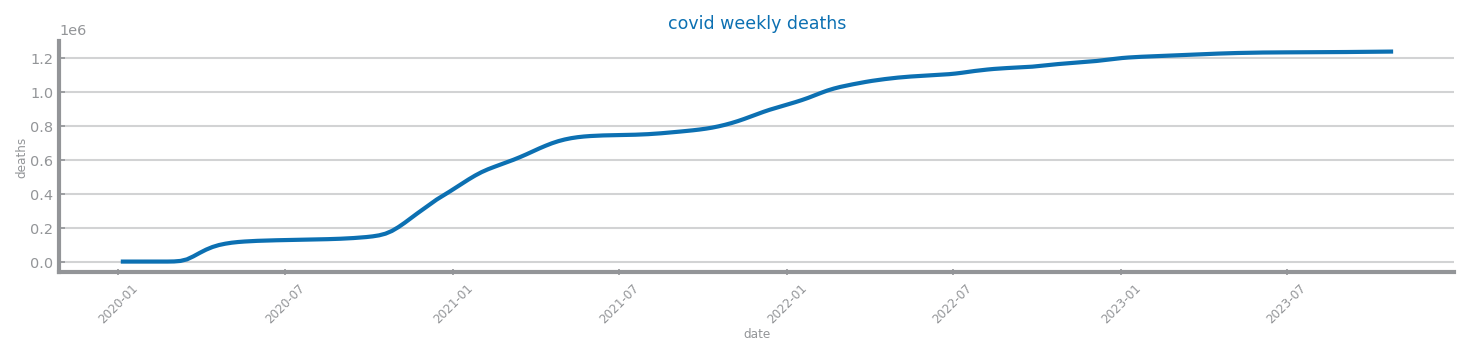

In [2]:
from matplotlib.pyplot import figure, show, savefig
from dslabs_functions import plot_line_chart, HEIGHT

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
savefig(f"images/{file_tag}/granularity/original_time_series.png")
show()

### aggregating by month and quarter (original is weekly)

[Timestamp('2020-01-06 00:00:00'), Timestamp('2020-01-13 00:00:00'), Timestamp('2020-01-20 00:00:00'), Timestamp('2020-01-27 00:00:00'), Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-10 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-02-24 00:00:00'), Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-20 00:00:00'), Timestamp('20

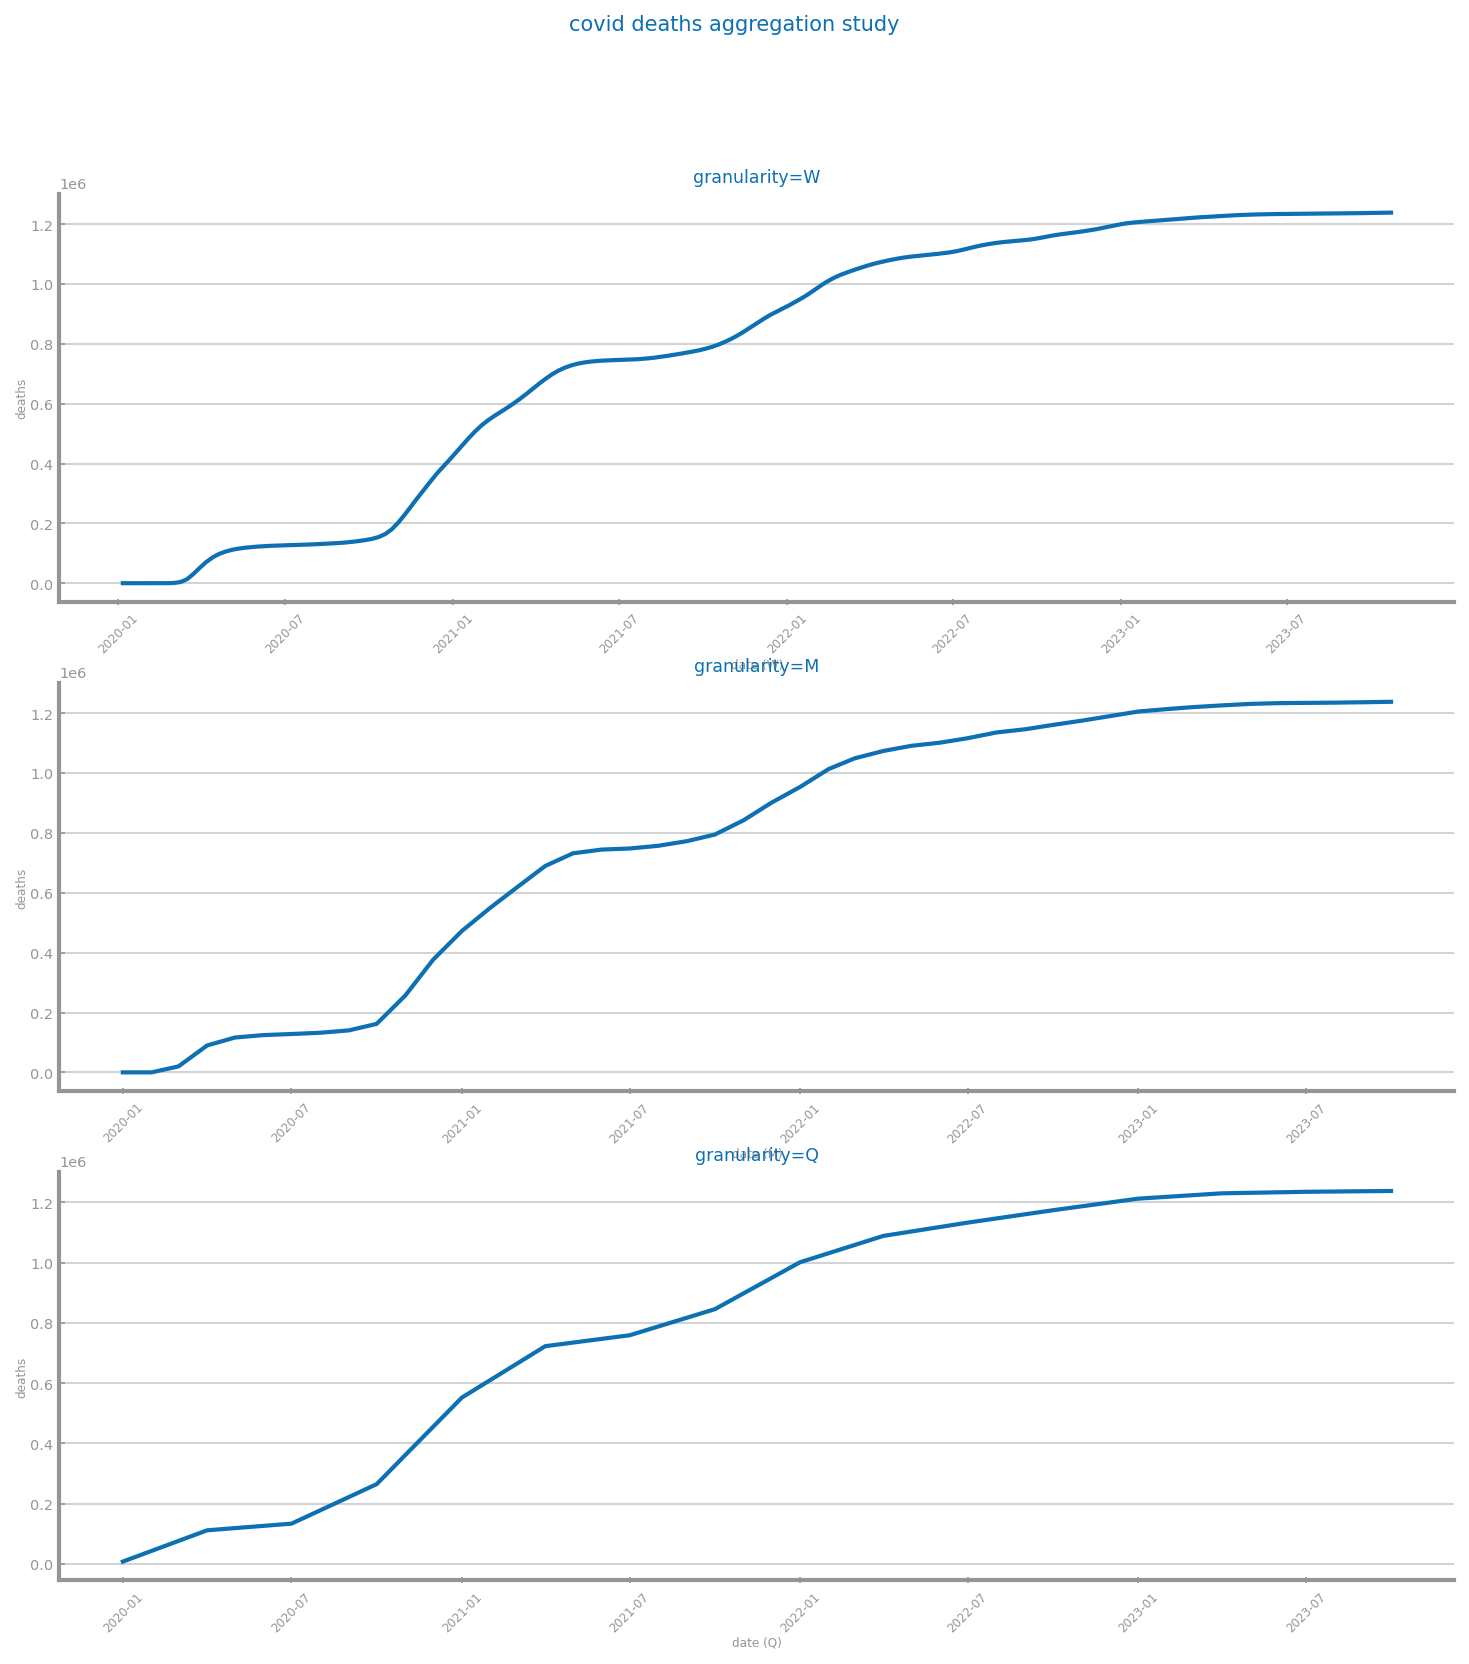

In [3]:
from matplotlib.pyplot import subplots, figure, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure


grans: list[str] = ["W", "M", "Q"]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(grans), 1, figsize=(3 * HEIGHT, HEIGHT * len(grans)))
fig.suptitle(f"{file_tag} {target} aggregation study")

for i in range(len(grans)):
    ss: Series = ts_aggregation_by(series, grans[i], agg_func="mean")
    ss.to_csv(f"data/{file_tag}/aggregation/{grans[i]}.csv")
    print(ss.index.to_list())
    plot_line_chart(
        ss.index.to_list(),
        ss.to_list(),
        ax=axs[i],
        xlabel=f"{ss.index.name} ({grans[i]})",
        ylabel=target,
        title=f"granularity={grans[i]}",
    )
savefig(f"images/{file_tag}/granularity/aggregation_study.png")
show()

# DISTRIBUTION

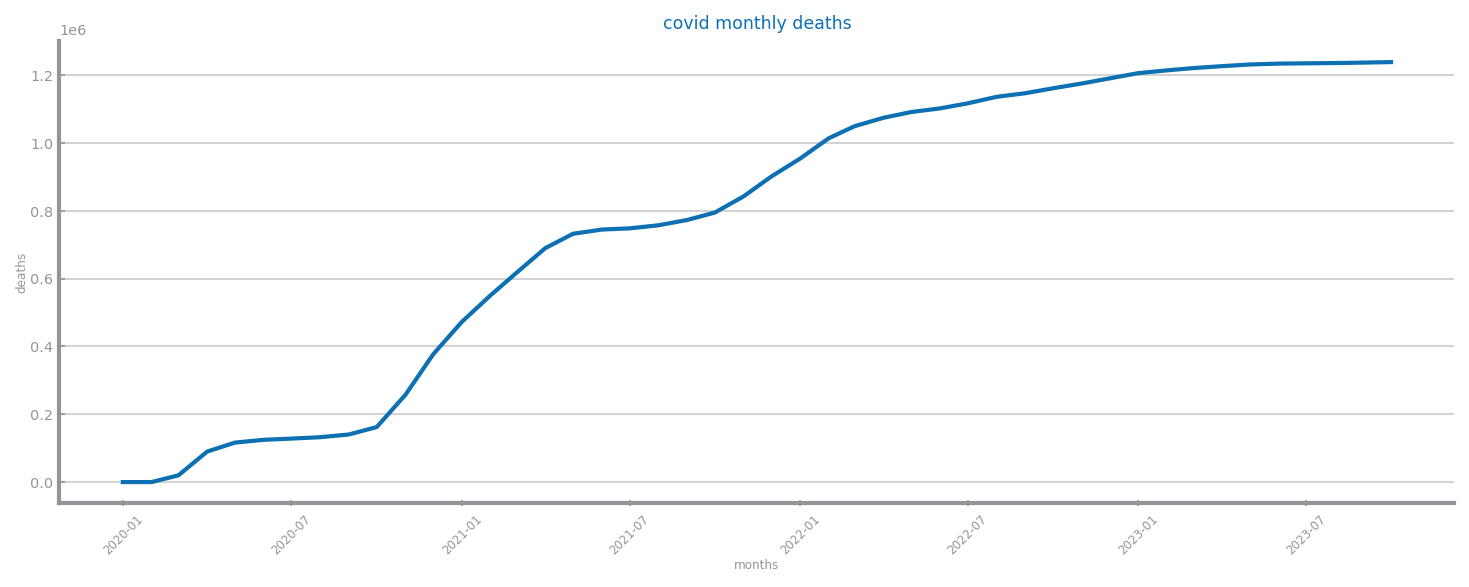

In [4]:
from numpy import sum
from pandas import Series
from matplotlib.pyplot import figure, show
from dslabs_functions import HEIGHT, plot_line_chart, ts_aggregation_by

ss_weeks: Series = ts_aggregation_by(series, gran_level="W", agg_func="mean")
ss_months: Series = ts_aggregation_by(series, gran_level="M", agg_func="mean")
ss_quarters: Series = ts_aggregation_by(series, gran_level="Q", agg_func="mean")

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_months.index.to_list(),
    ss_months.to_list(),
    xlabel="months",
    ylabel=target,
    title=f"{file_tag} monthly {target}",
)
show()

### BOXPLOTS

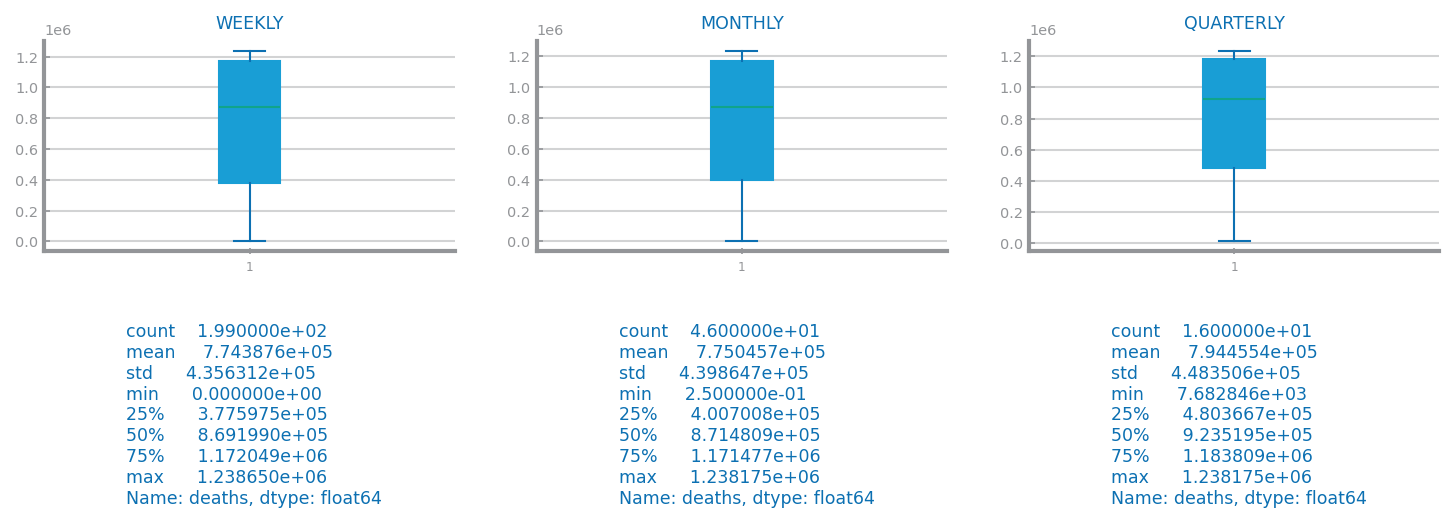

In [5]:
from numpy import array
from matplotlib.pyplot import show, subplots
from matplotlib.figure import Figure
from dslabs_functions import set_chart_labels

fig: Figure
axs: array
fig, axs = subplots(2, 3, figsize=(3 * HEIGHT, HEIGHT))
set_chart_labels(axs[0, 0], title="WEEKLY")
axs[0, 0].boxplot(series)
set_chart_labels(axs[0, 1], title="MONTHLY")
axs[0, 1].boxplot(ss_months)
set_chart_labels(axs[0, 2], title="QUARTERLY")
axs[0, 2].boxplot(ss_quarters)

axs[1, 0].grid(False)
axs[1, 0].set_axis_off()
axs[1, 0].text(0.2, 0, str(series.describe()), fontsize="small")

axs[1, 1].grid(False)
axs[1, 1].set_axis_off()
axs[1, 1].text(0.2, 0, str(ss_months.describe()), fontsize="small")

axs[1, 2].grid(False)
axs[1, 2].set_axis_off()
axs[1, 2].text(0.2, 0, str(ss_quarters.describe()), fontsize="small")
savefig(f"images/{file_tag}/distribution/boxplots.png")
show()

### HISTOGRAMS

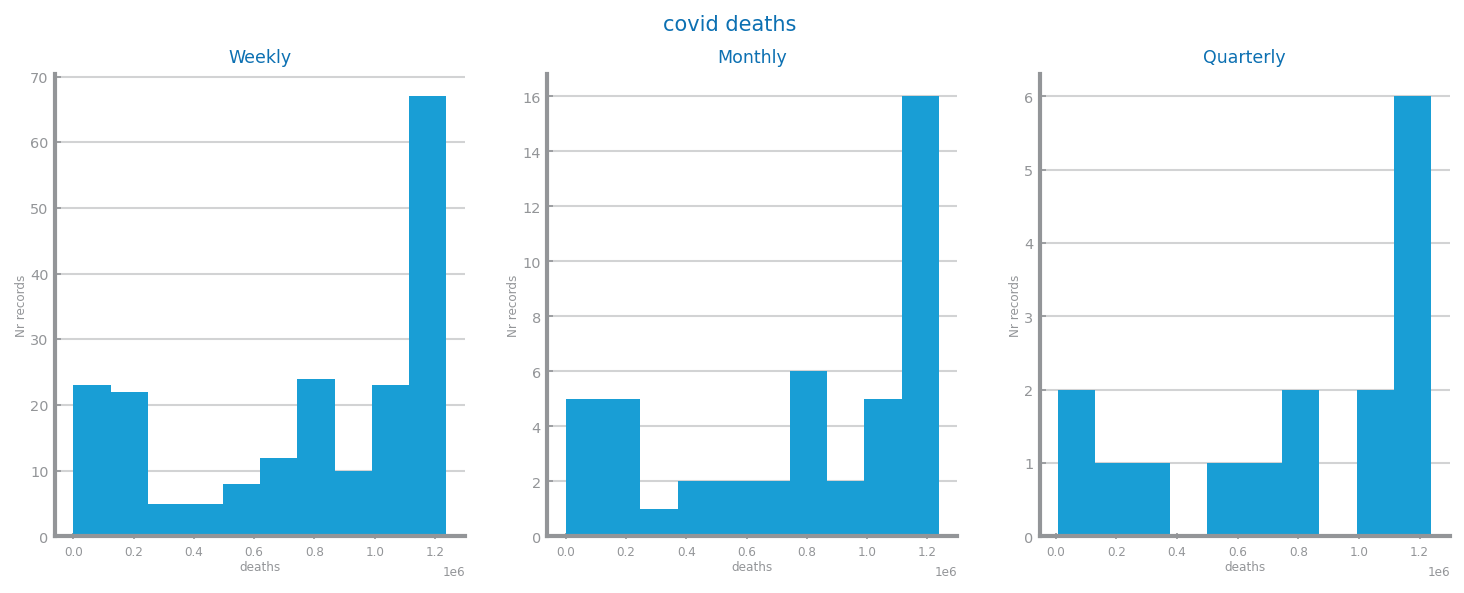

In [6]:
grans: list[Series] = [ss_weeks, ss_months, ss_quarters]
gran_names: list[str] = ["Weekly", "Monthly", "Quarterly"]
fig: Figure
axs: array
fig, axs = subplots(1, len(grans), figsize=(len(grans) * HEIGHT, HEIGHT))
fig.suptitle(f"{file_tag} {target}")
for i in range(len(grans)):
    set_chart_labels(axs[i], title=f"{gran_names[i]}", xlabel=target, ylabel="Nr records")
    axs[i].hist(grans[i].values)
savefig(f"images/{file_tag}/distribution/histograms.png")
show()

### LAG-PLOTS

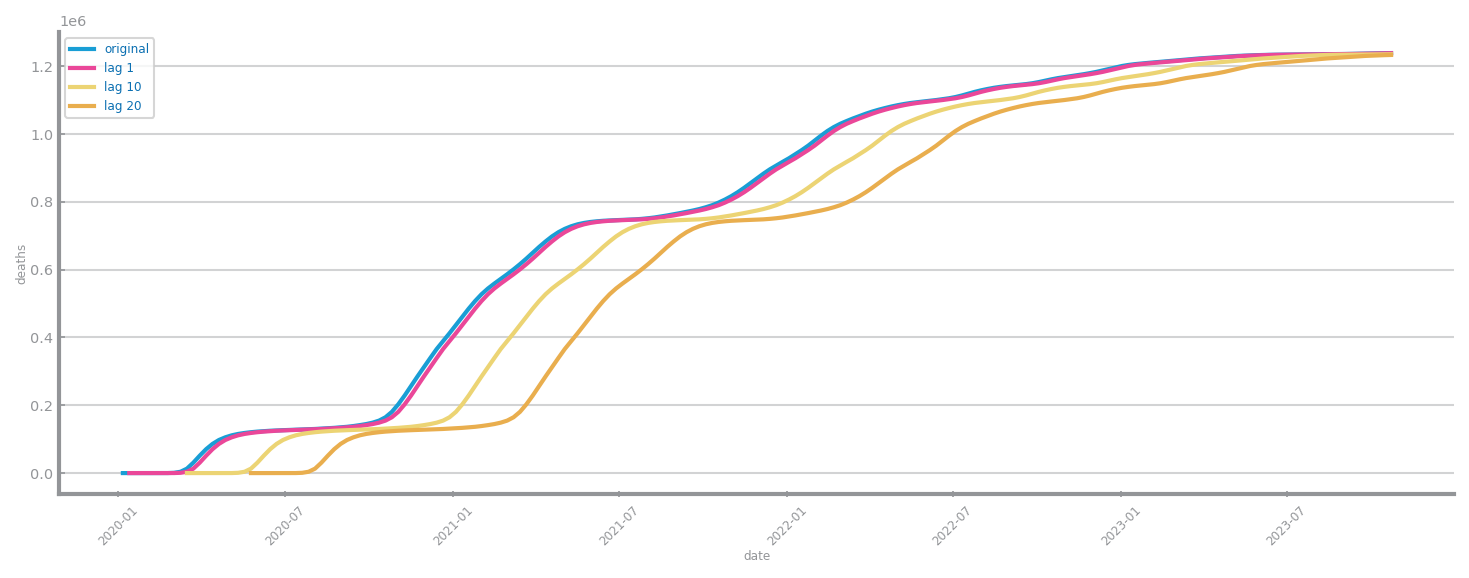

In [7]:
from dslabs_functions import plot_multiline_chart


def get_lagged_series(series: Series, max_lag: int, delta: int = 1):
    lagged_series: dict = {"original": series, "lag 1": series.shift(1)}
    for i in range(delta, max_lag + 1, delta):
        lagged_series[f"lag {i}"] = series.shift(i)
    return lagged_series


figure(figsize=(3 * HEIGHT, HEIGHT))
lags = get_lagged_series(series, 20, 10)
plot_multiline_chart(series.index.to_list(), lags, xlabel=index, ylabel=target)
savefig(f"images/{file_tag}/distribution/lag_plots.png")

### CORRELOGRAM

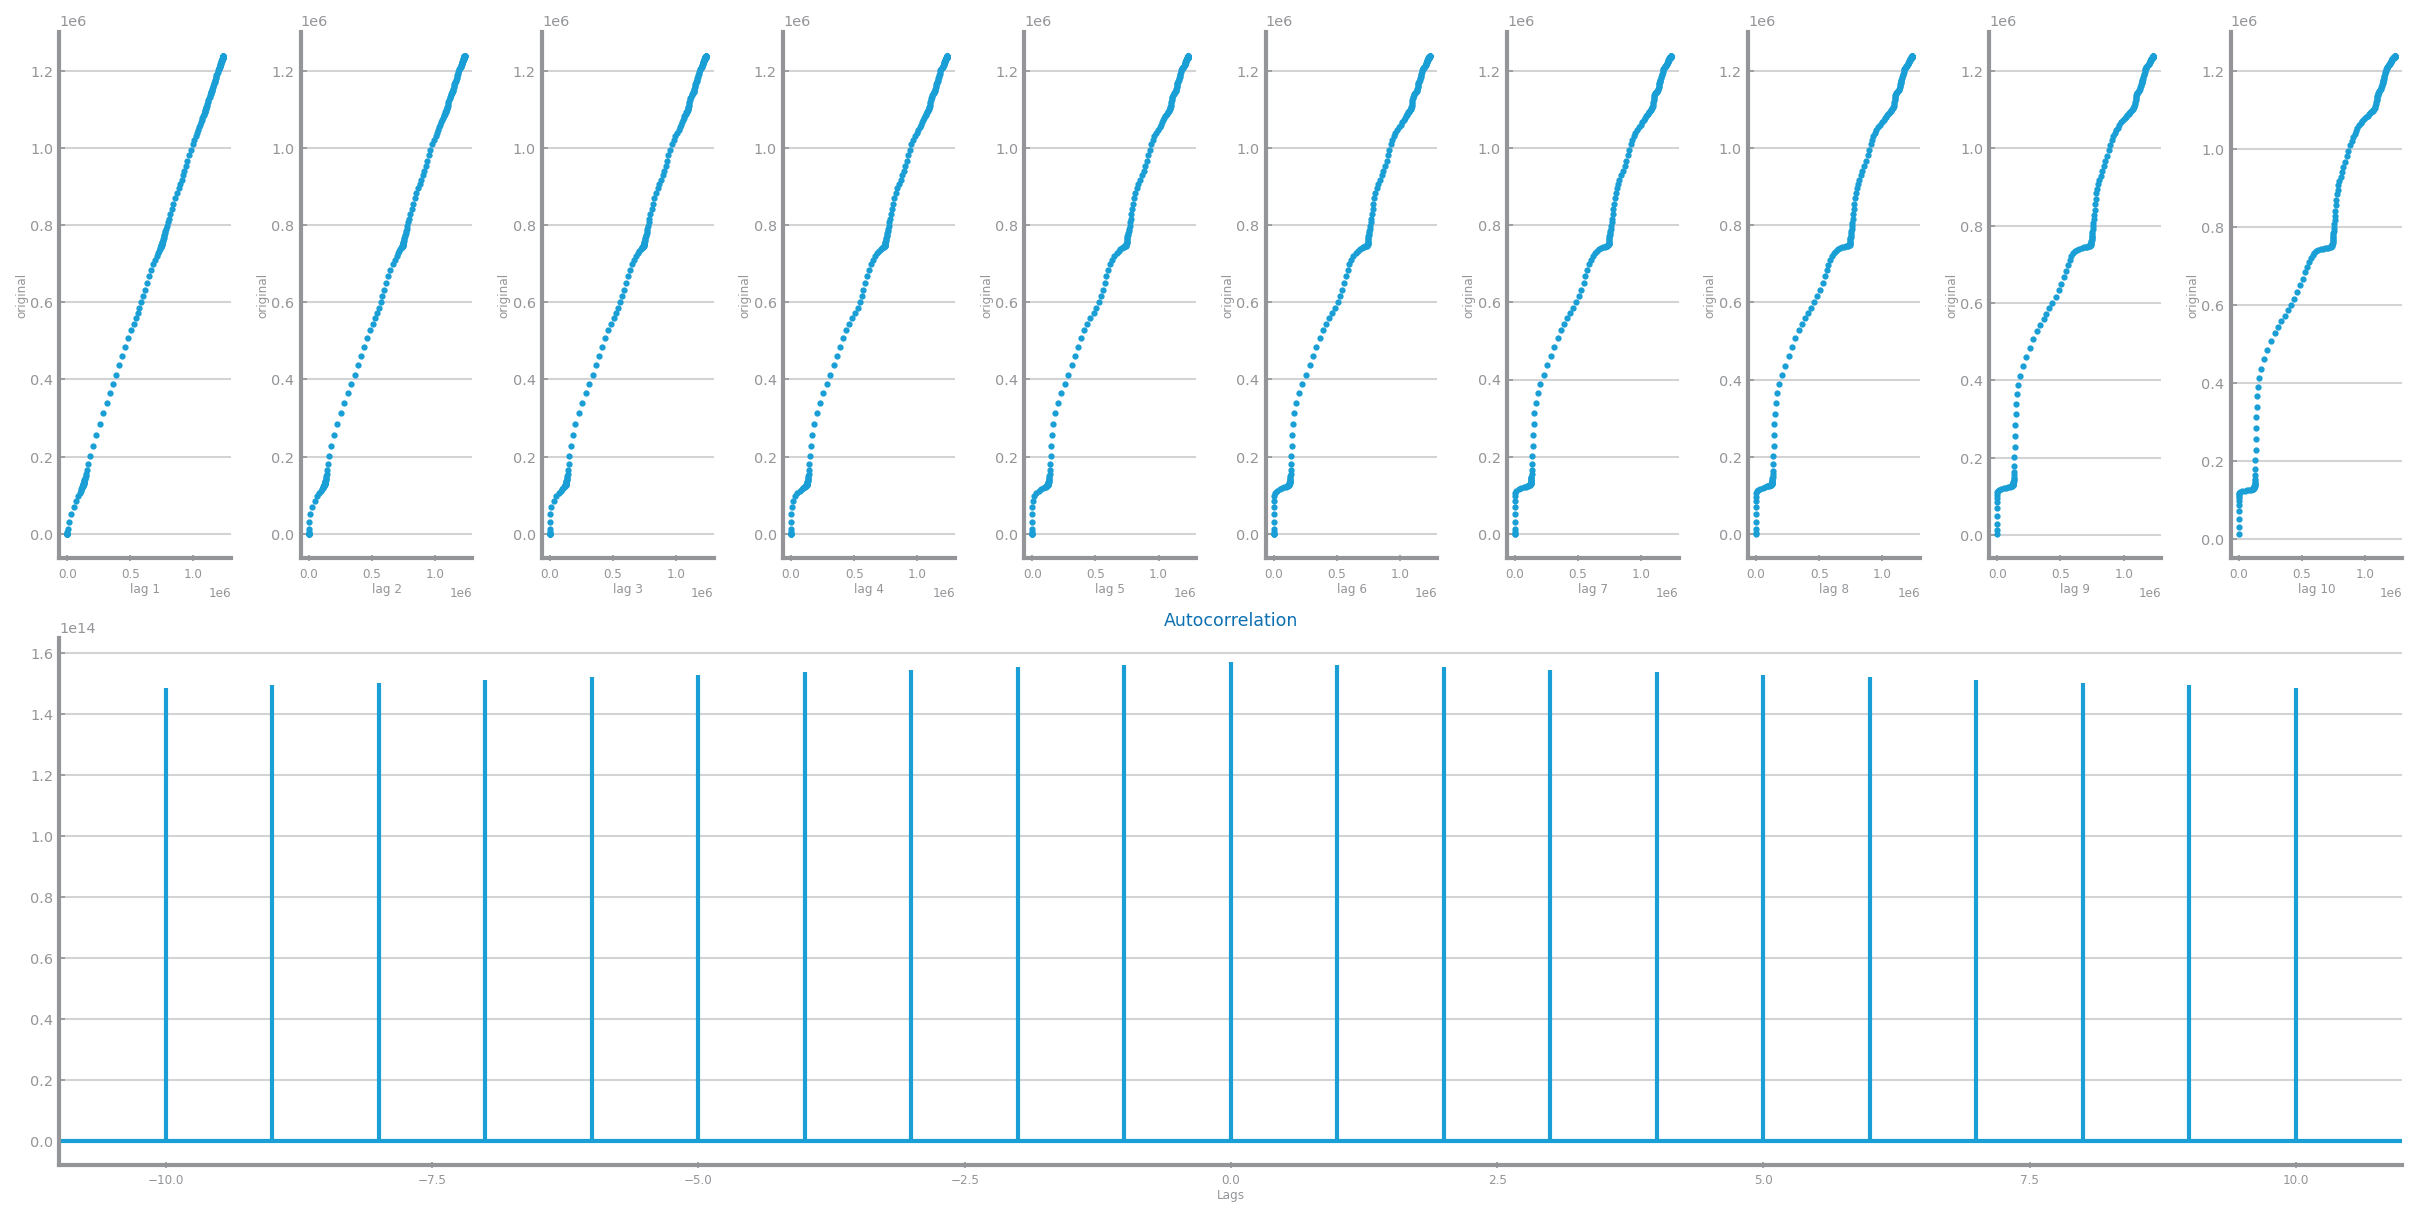

In [8]:
from matplotlib.pyplot import setp
from matplotlib.gridspec import GridSpec


def autocorrelation_study(series: Series, max_lag: int, delta: int = 1):
    k: int = int(max_lag / delta)
    fig = figure(figsize=(4 * HEIGHT, 2 * HEIGHT), constrained_layout=True)
    gs = GridSpec(2, k, figure=fig)

    series_values: list = series.tolist()
    for i in range(1, k + 1):
        ax = fig.add_subplot(gs[0, i - 1])
        lag = i * delta
        ax.scatter(series.shift(lag).tolist(), series_values)
        ax.set_xlabel(f"lag {lag}")
        ax.set_ylabel("original")
    ax = fig.add_subplot(gs[1, :])
    ax.acorr(series, maxlags=max_lag, normed=False)
    ax.set_title("Autocorrelation")
    ax.set_xlabel("Lags")
    return


autocorrelation_study(series, 10, 1)
savefig(f"images/{file_tag}/distribution/correlogram.png")

# STATIONARITY

### COMPONENT STUDY

In [9]:
from pandas import Series
from matplotlib.pyplot import subplots, show, gca
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
from dslabs_functions import HEIGHT, set_chart_labels


def plot_components(
    series: Series,
    title: str = "",
    x_label: str = "time",
    y_label: str = "",
) -> list[Axes]:
    decomposition: DecomposeResult = seasonal_decompose(series, model="add")
    components: dict = {
        "observed": series,
        "trend": decomposition.trend,
        "seasonal": decomposition.seasonal,
        "residual": decomposition.resid,
    }
    rows: int = len(components)
    fig: Figure
    axs: list[Axes]
    fig, axs = subplots(rows, 1, figsize=(3 * HEIGHT, rows * HEIGHT))
    fig.suptitle(f"{title}")
    i: int = 0
    for key in components:
        set_chart_labels(axs[i], title=key, xlabel=x_label, ylabel=y_label)
        axs[i].plot(components[key])
        i += 1
    return axs

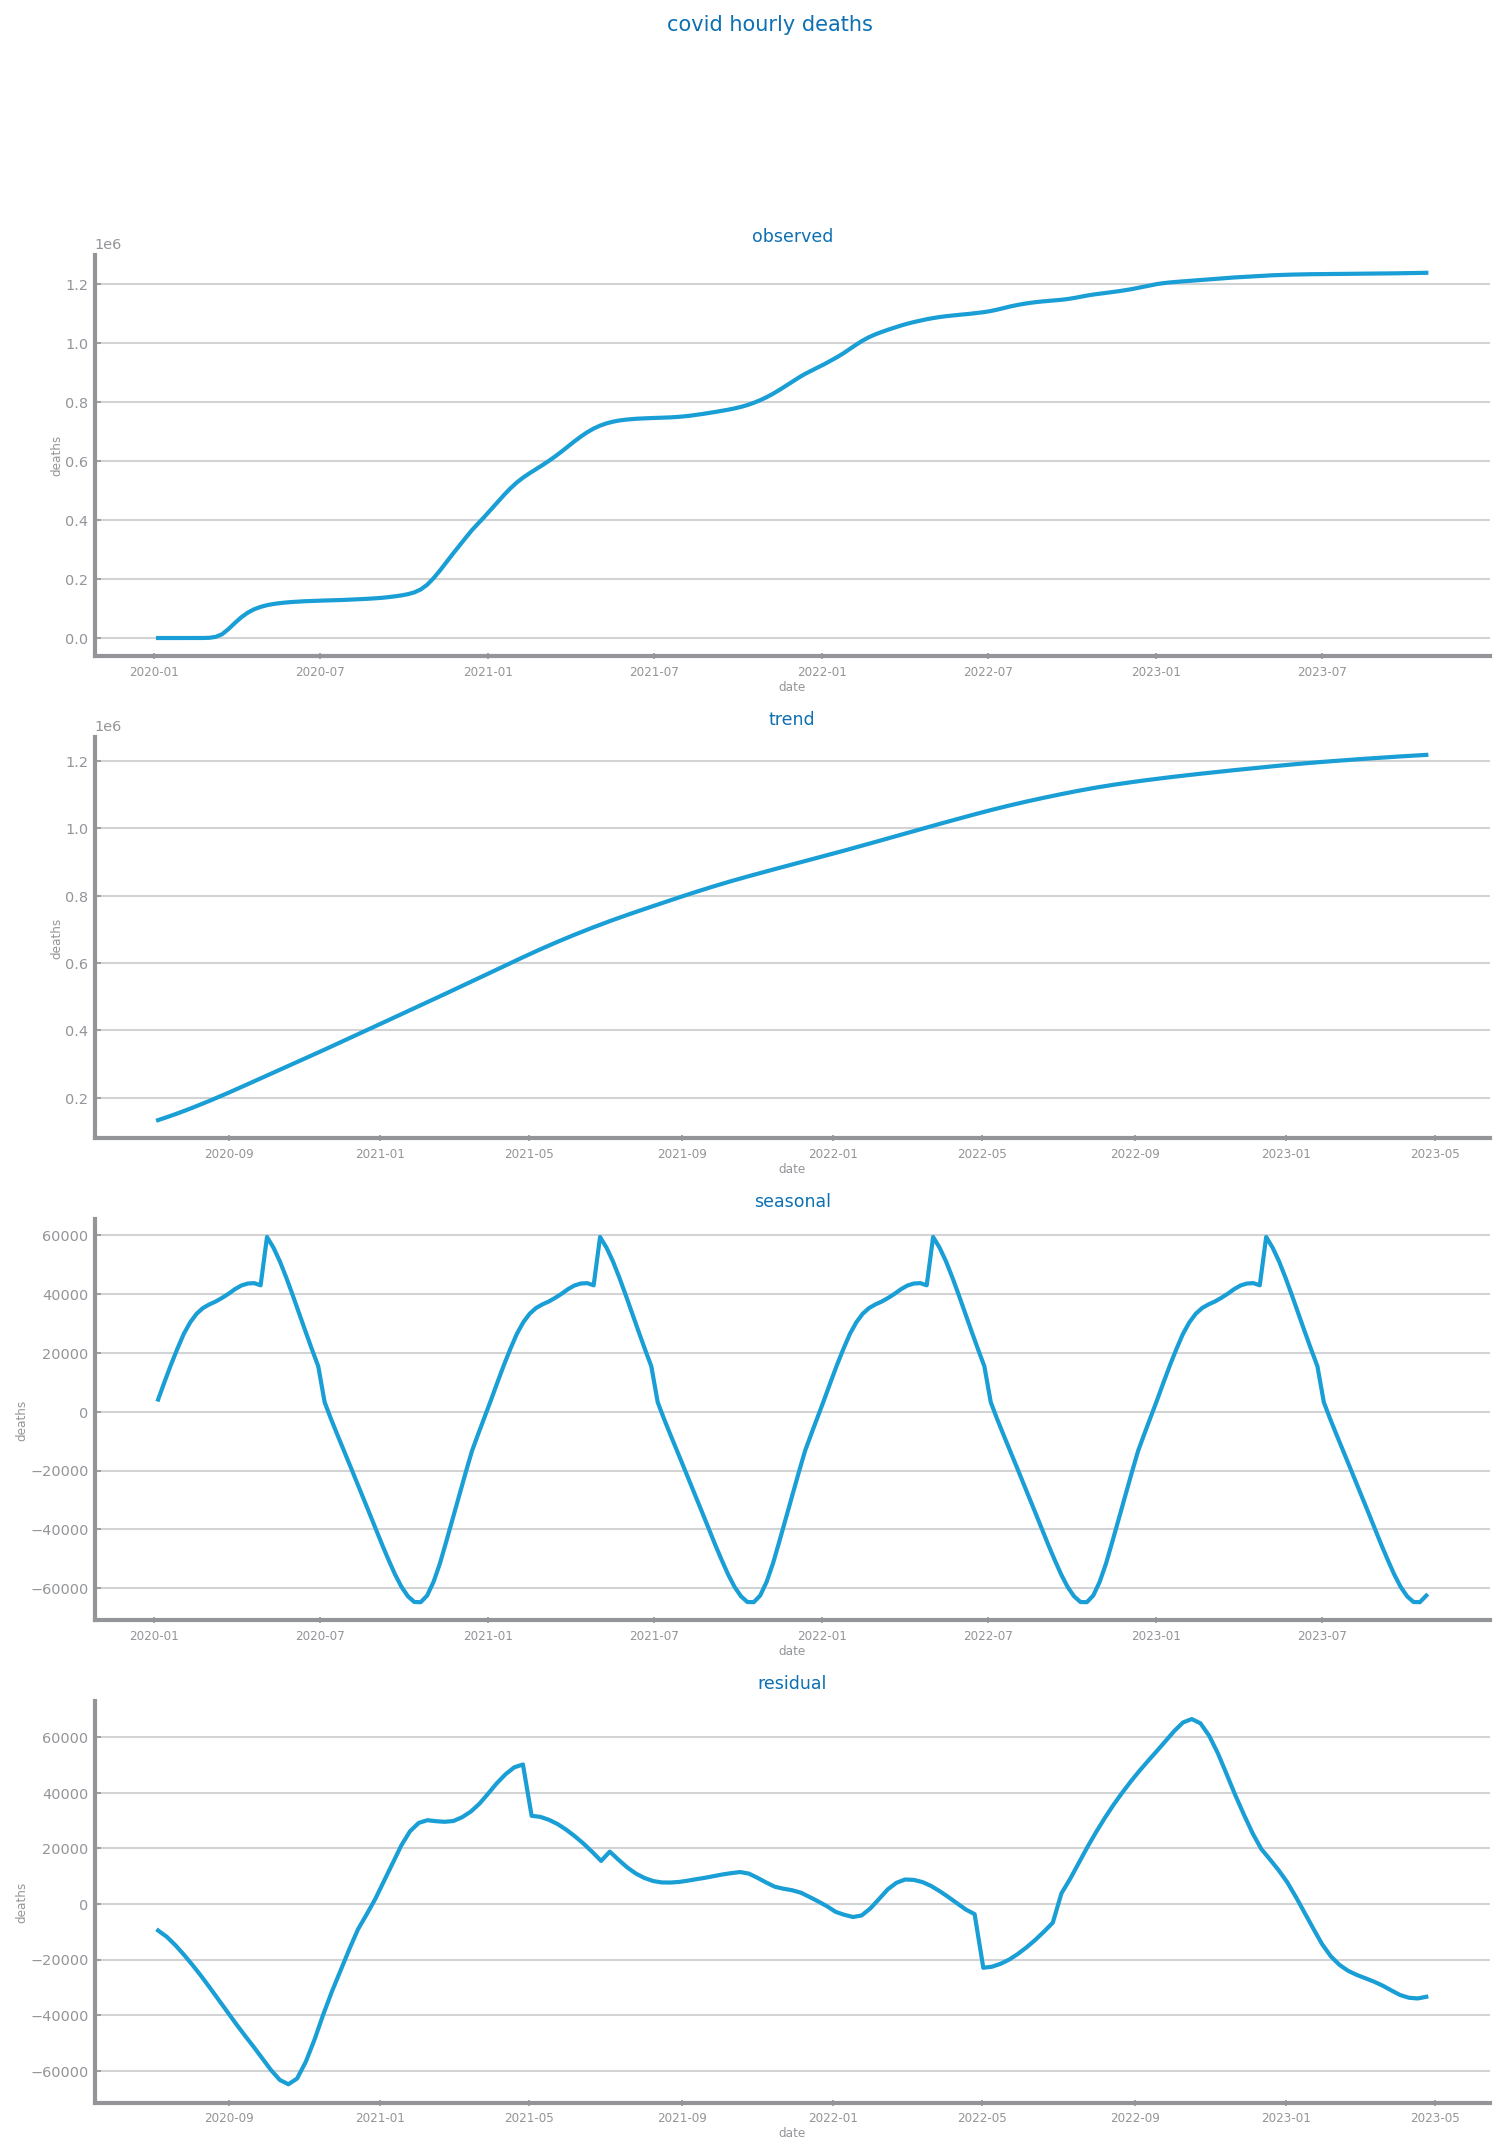

In [10]:
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart

plot_components(
    series,
    title=f"{file_tag} hourly {target}",
    x_label=series.index.name,
    y_label=target,
)
savefig(f"images/{file_tag}/stationarity/components_study.png")
show()

### STATIONARY STUDY

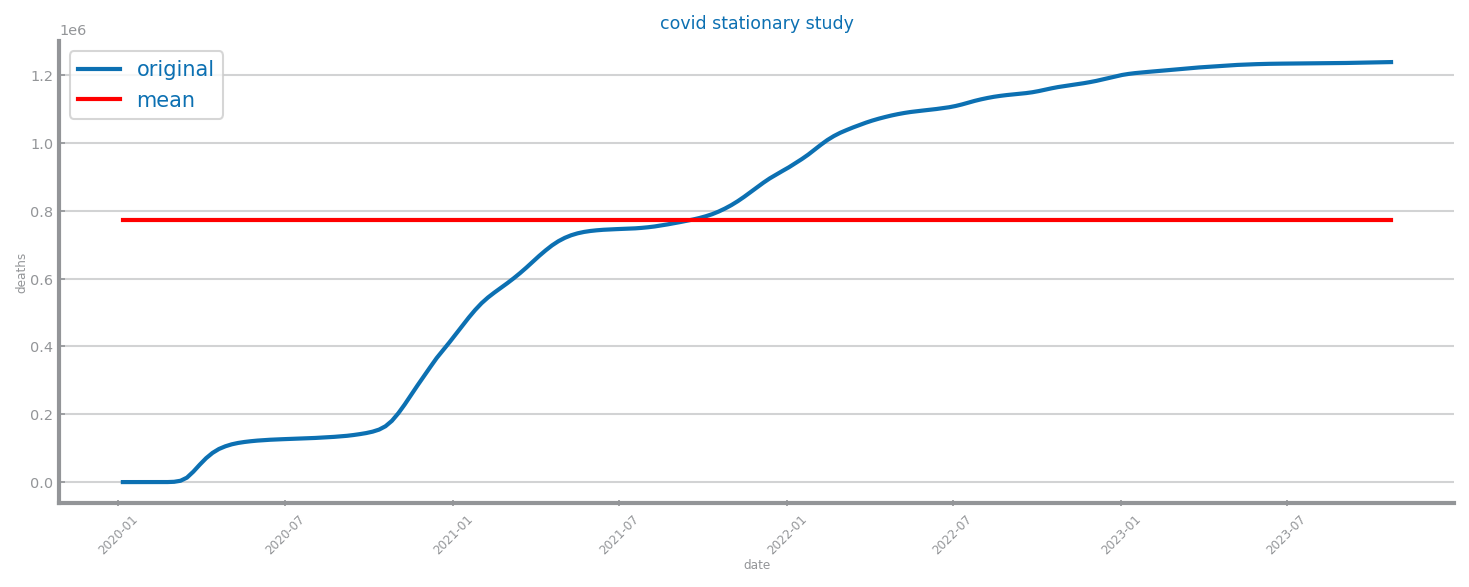

In [11]:
from matplotlib.pyplot import plot, legend

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
)
n: int = len(series)
plot(series.index, [series.mean()] * n, "r-", label="mean")
legend()
#savefig(f"images/{file_tag}/stationarity/stationarity_study.png")
show()

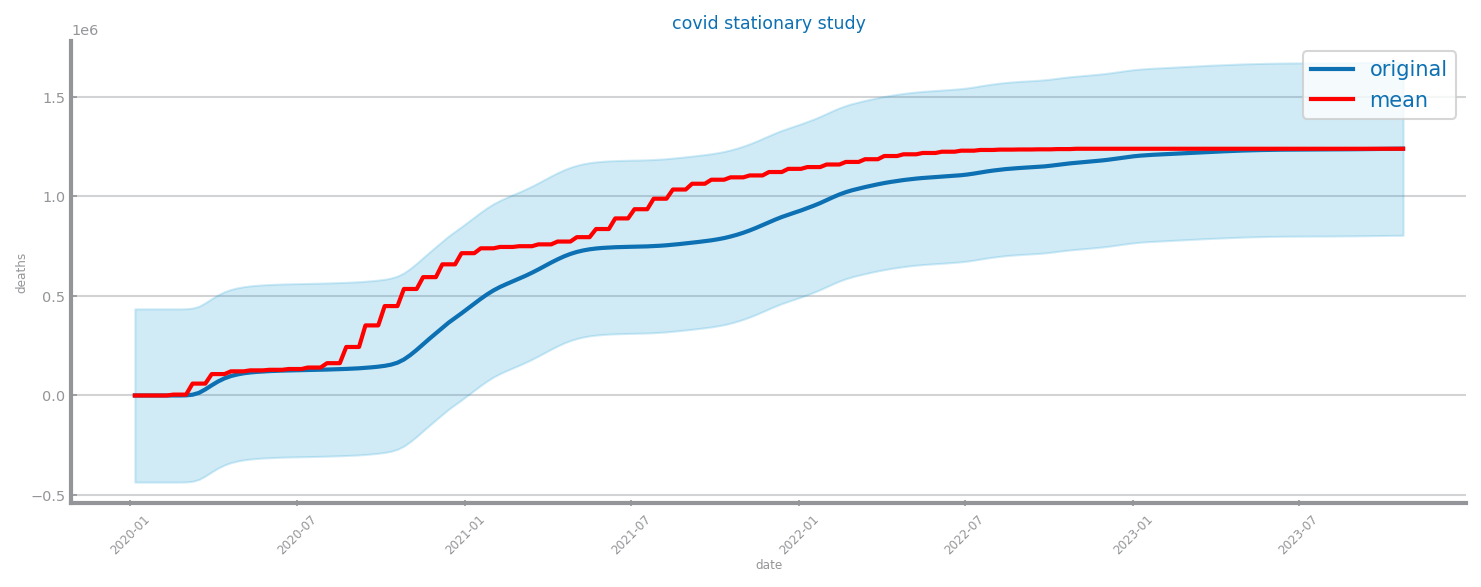

In [12]:
BINS = 50
mean_line: list[float] = []

for i in range(BINS):
    segment: Series = series[i * n // BINS : (i + 1) * n // BINS]
    mean_value: list[float] = [segment.mean()] * (n // BINS)
    mean_line += mean_value
mean_line += [mean_line[-1]] * (n - len(mean_line))

figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} stationary study",
    name="original",
    show_stdev=True,
)
n: int = len(series)
plot(series.index, mean_line, "r-", label="mean")
legend()
savefig(f"images/{file_tag}/stationarity/stationarity_study.png")
show()

### AUGMENTED DICKEY-FULLER TEST

In [13]:
from statsmodels.tsa.stattools import adfuller


def eval_stationarity(series: Series) -> bool:
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    return result[1] <= 0.05


print(f"The series {('is' if eval_stationarity(series) else 'is not')} stationary")

ADF Statistic: -2.156
p-value: 0.223
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575
The series is not stationary


# EVALUATION (LINEAR REGRESSION)

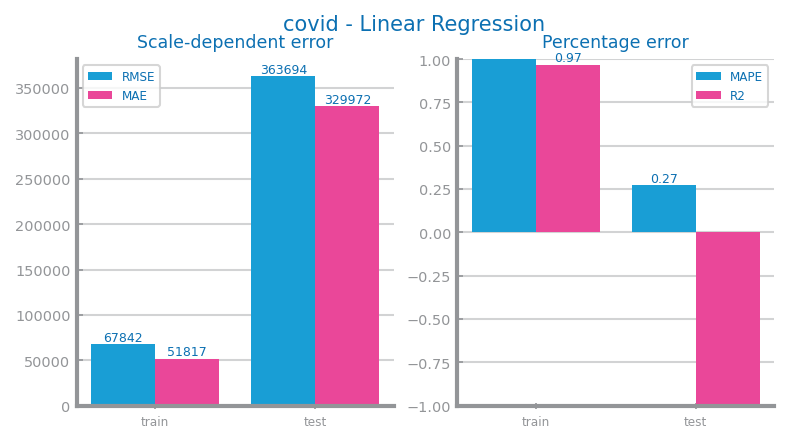

In [10]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, plot_forecasting_eval

filename: str = "data/covid/forecast_covid_single.csv"
file_tag: str = "covid"
target: str = "deaths"
timecol: str = "date"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.67)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/linear_regression_eval.png")

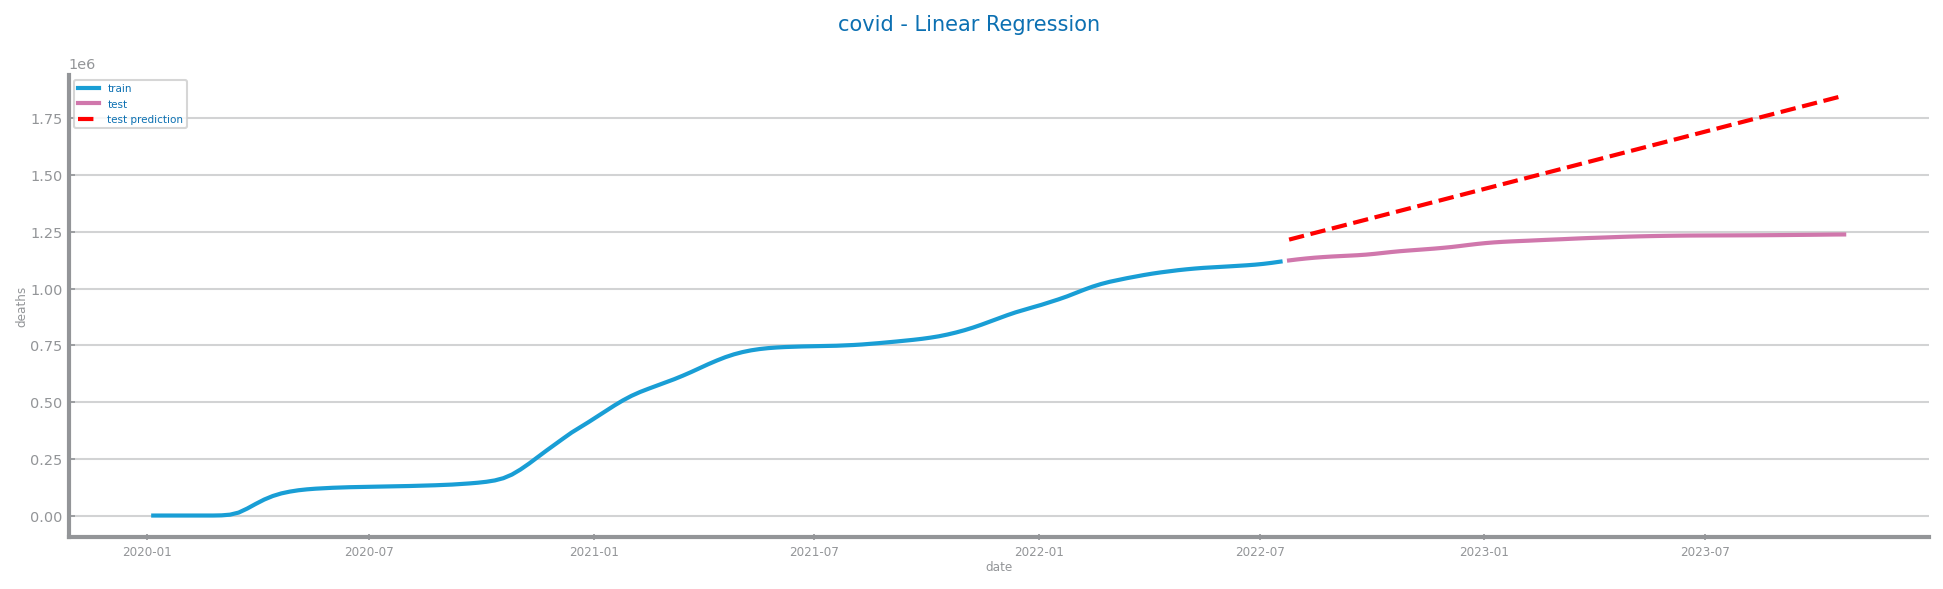

In [12]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/linear_regression_forecast.png")

# AGGREGATION

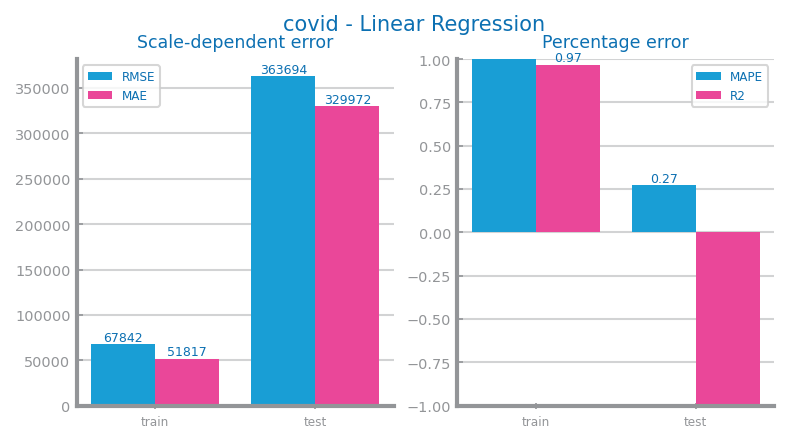

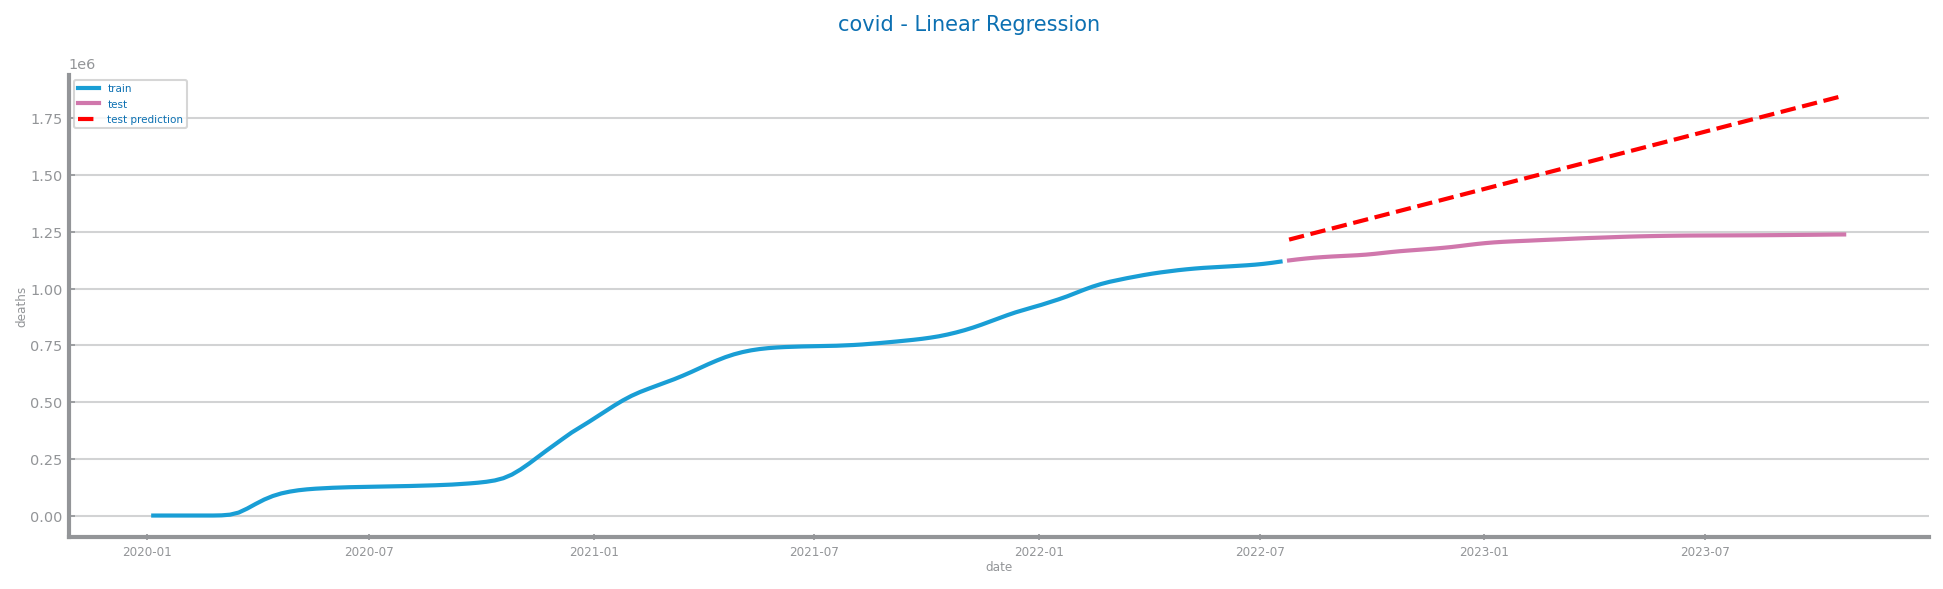

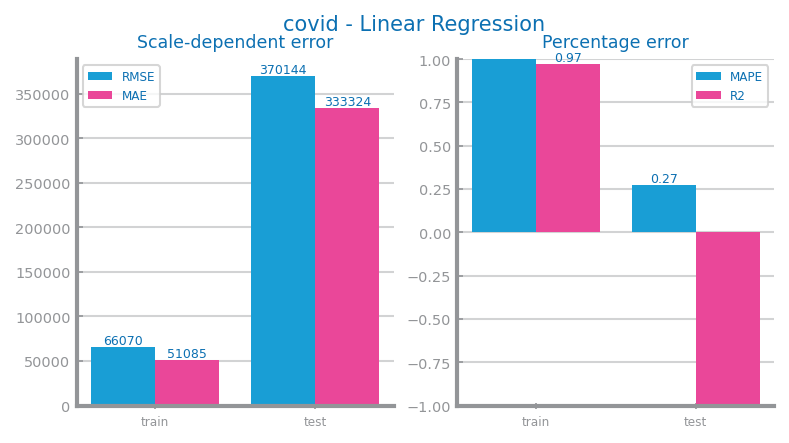

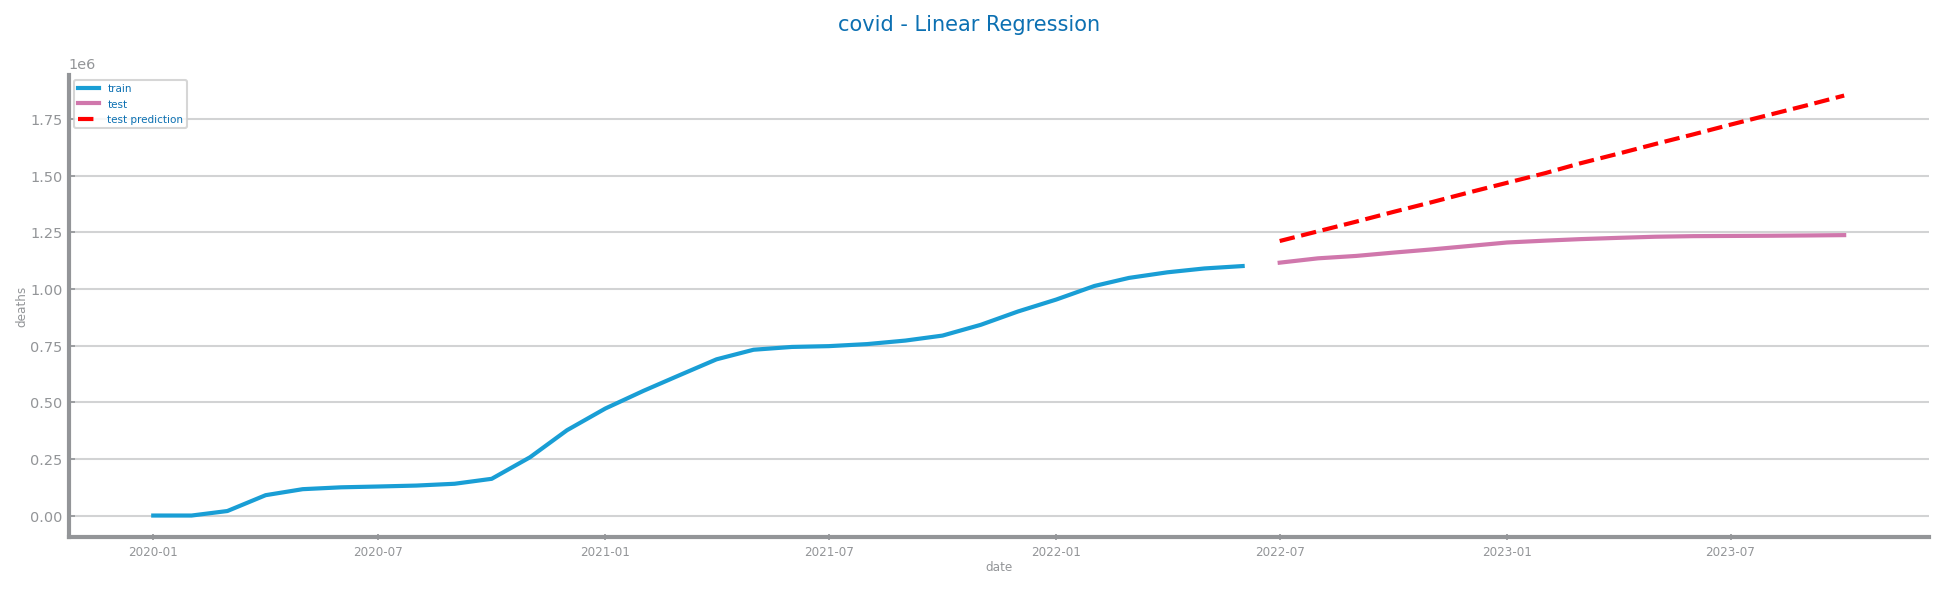

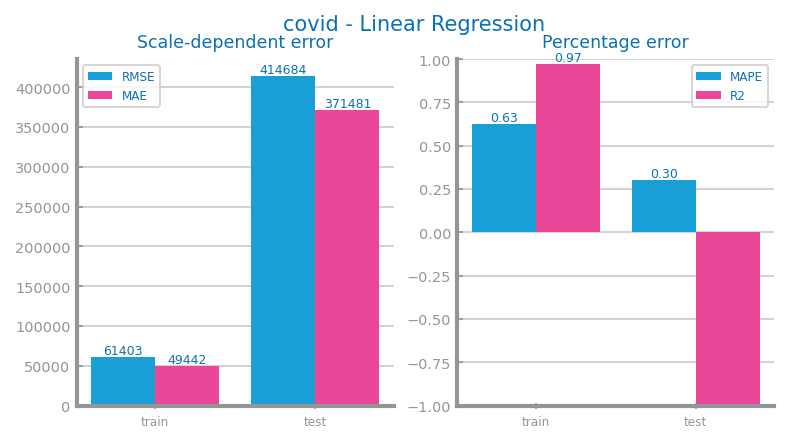

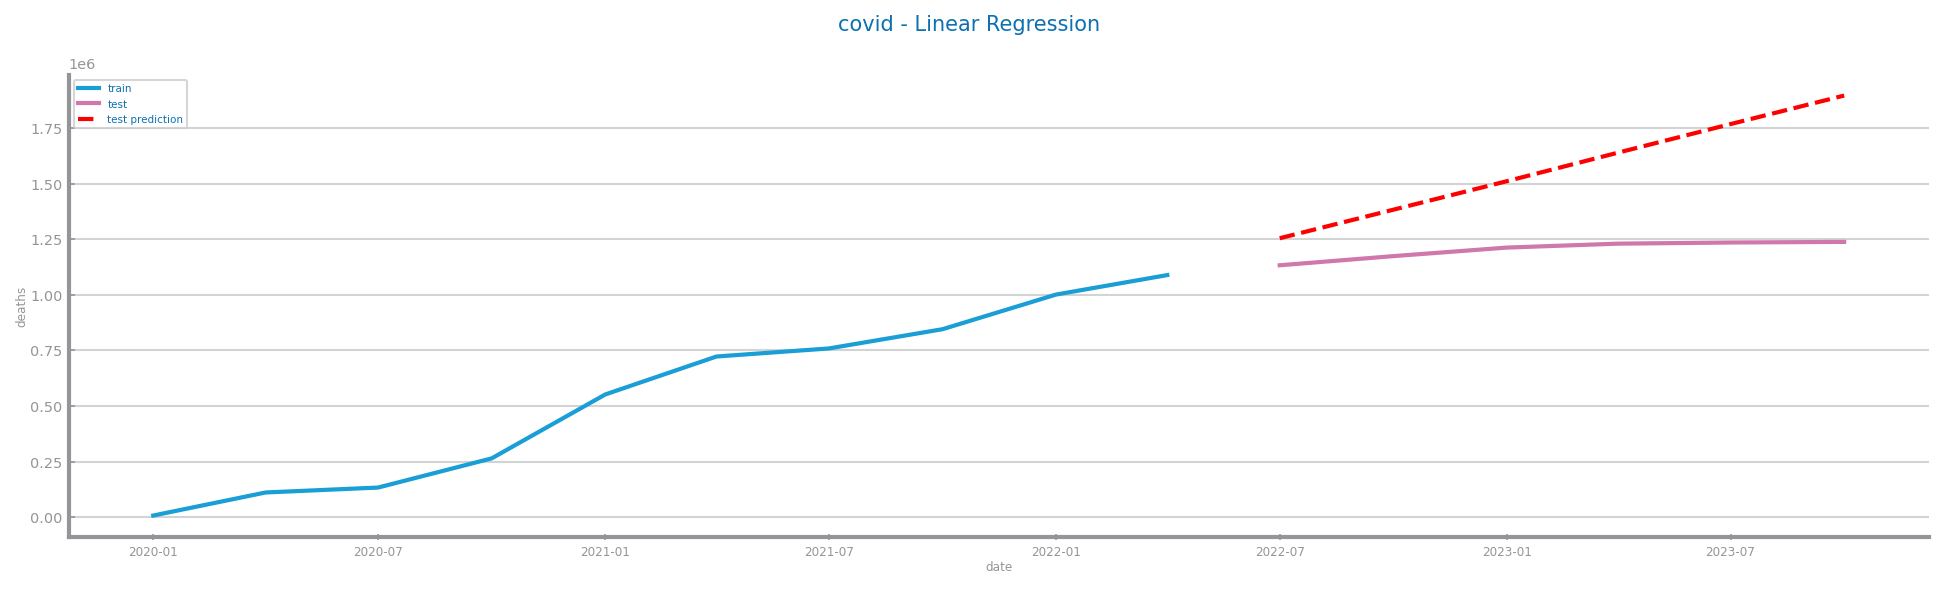

In [13]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, ts_aggregation_by, HEIGHT

gran_letters = ["W", "M", "Q"]

for i in range(len(gran_letters)):
    ss_data: DataFrame = read_csv(f"data/{file_tag}/aggregation/{gran_letters[i]}.csv", index_col=timecol, sep=",", decimal=".", parse_dates=True)
    train, test = series_train_test_split(ss_data, trn_pct=0.67)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(ss_data)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    plot_forecasting_eval(
        train, 
        test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} - Linear Regression"
    )
    savefig(f"images/{file_tag}/aggregation/{gran_letters[i]}_linear_regression_eval.png")

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"images/{file_tag}/aggregation/{gran_letters[i]}_linear_regression_forecast.png")
show()

# SMOOTHING

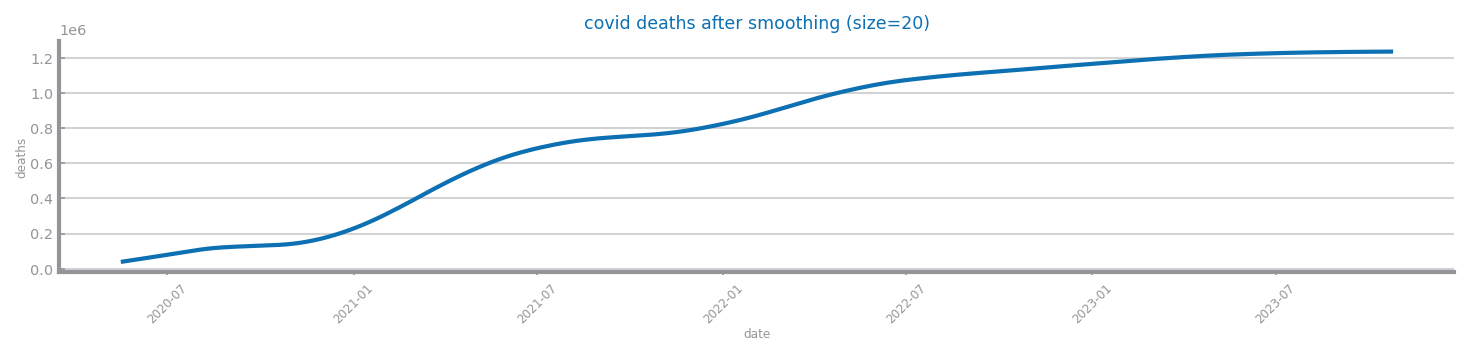

In [29]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

#filename: str = f"data/{file_tag}/aggregation/W.csv"
filename: str = f"data/{file_tag}/forecast_covid_single.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

WIN_SIZE = 20
ss_smooth: Series = series.rolling(window=WIN_SIZE).mean()

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    ss_smooth.index.to_list(),
    ss_smooth.to_list(),
    xlabel=ss_smooth.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after smoothing (size={WIN_SIZE})",
)
show()

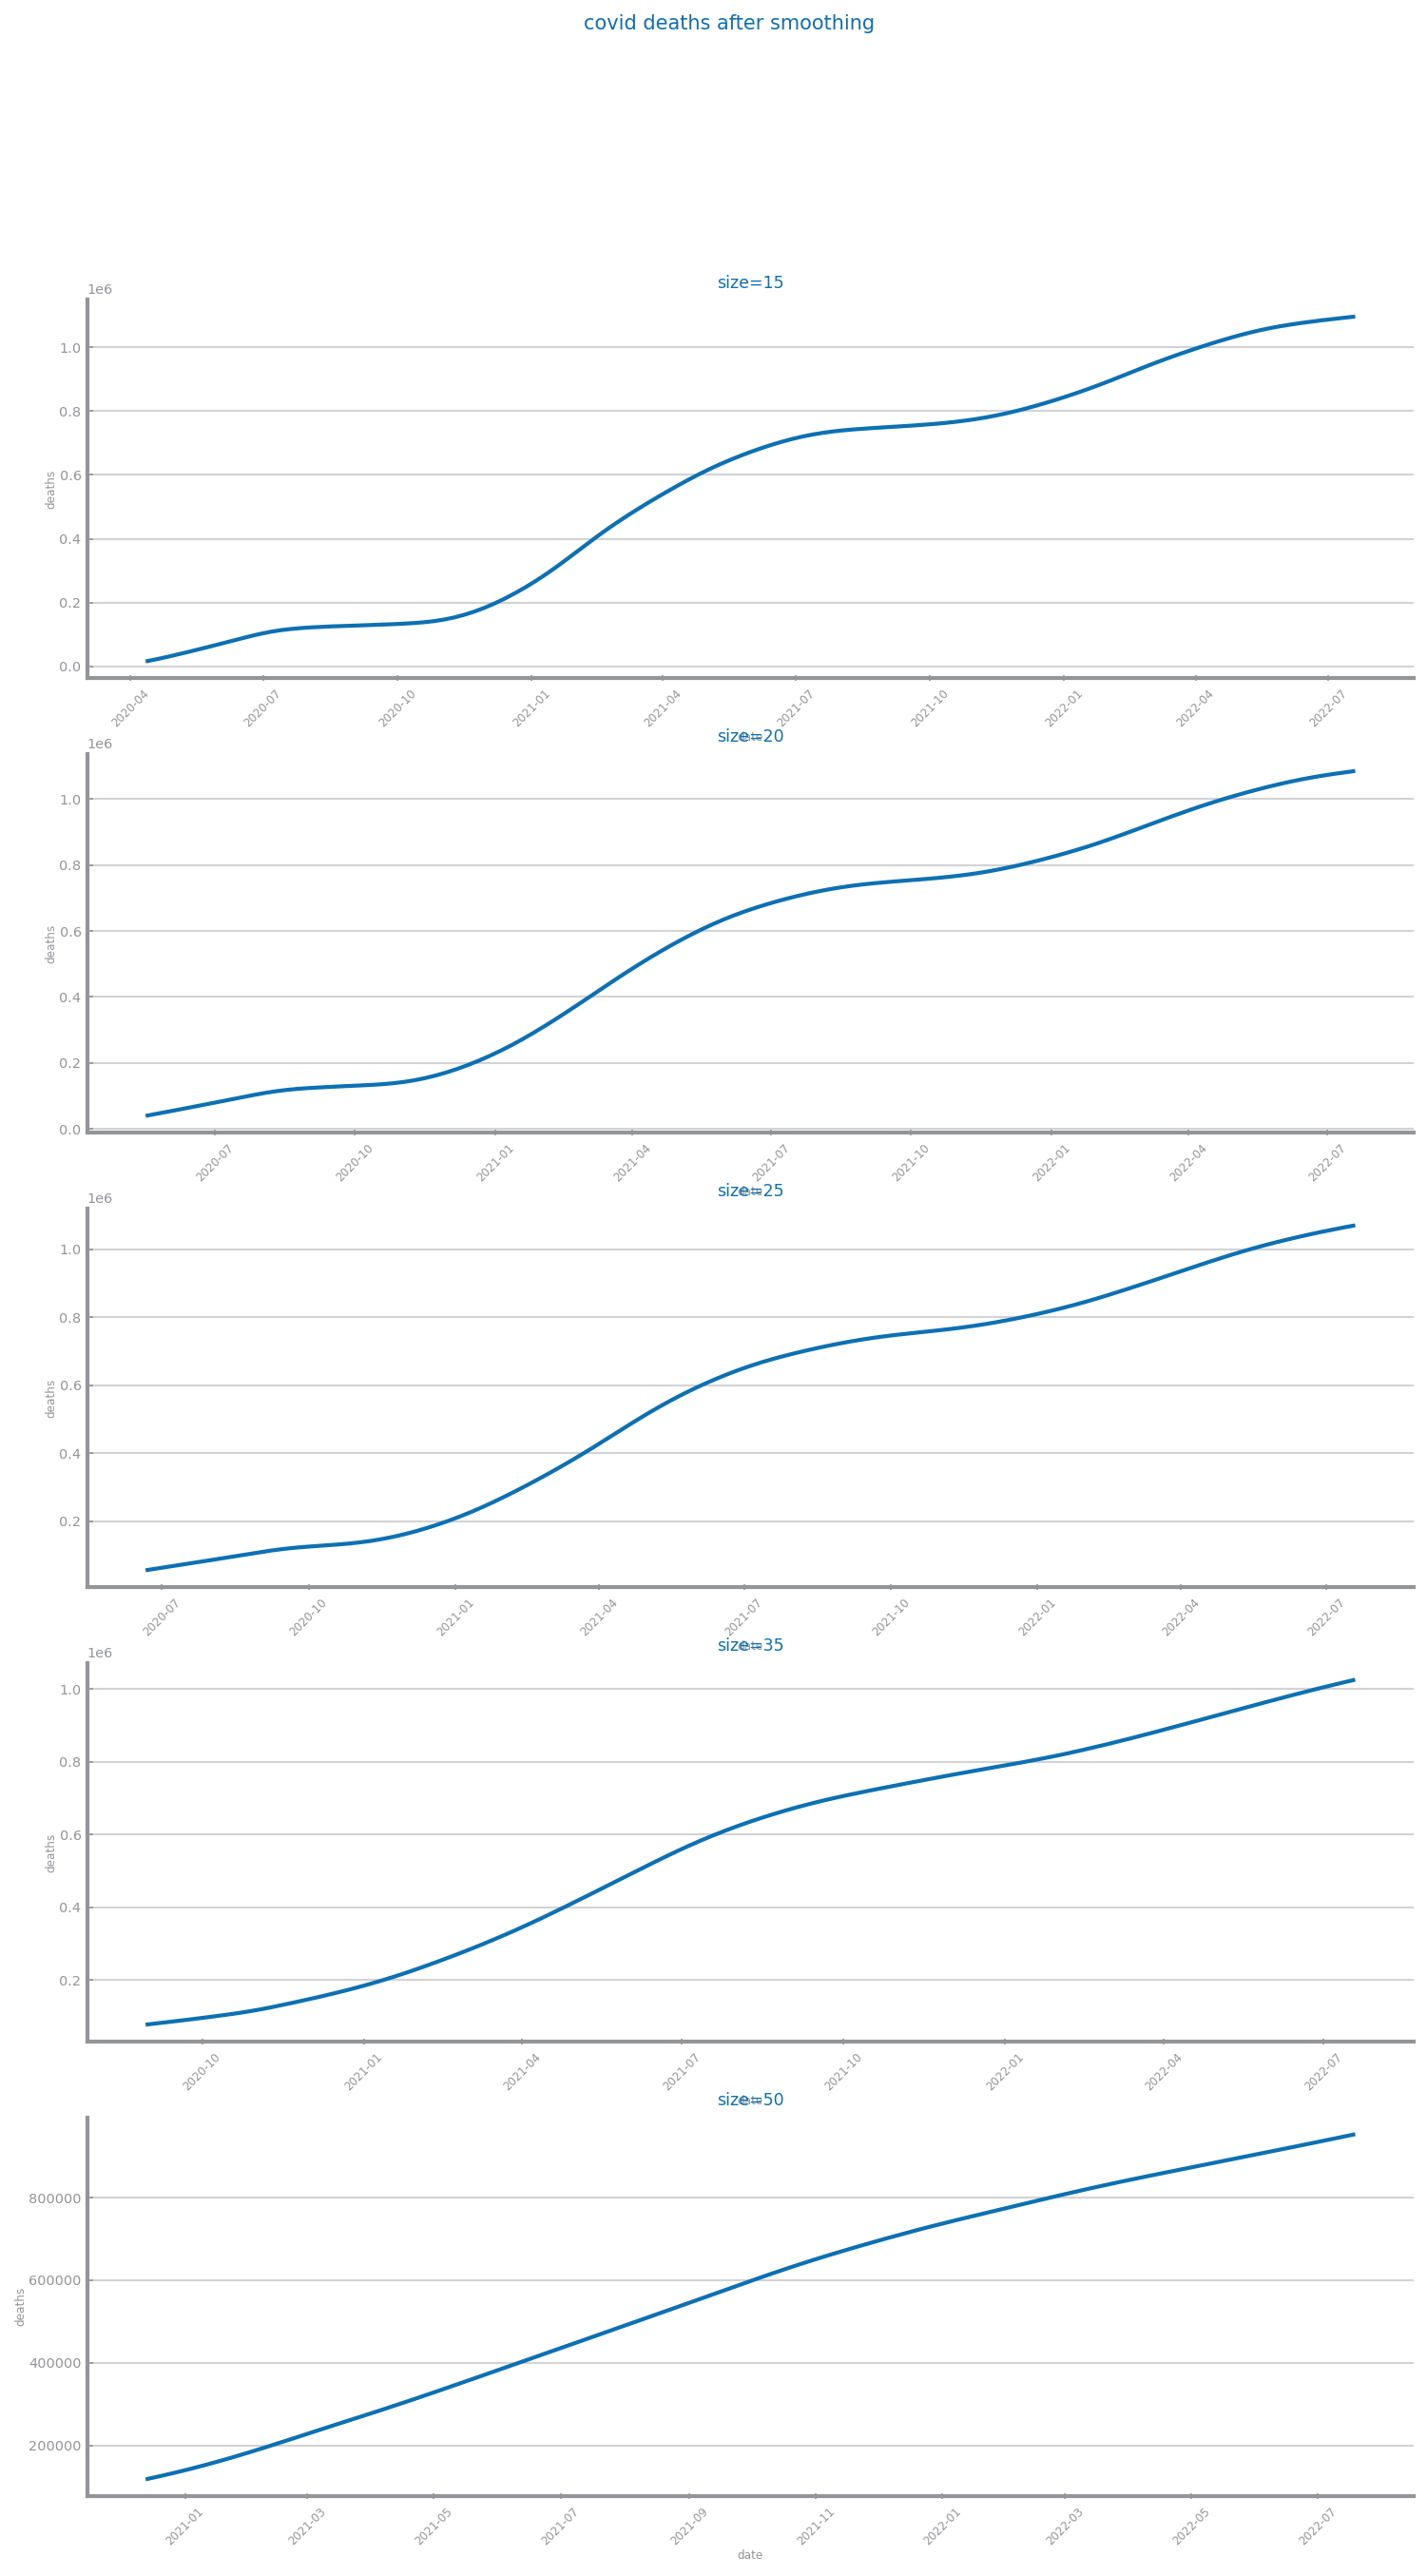

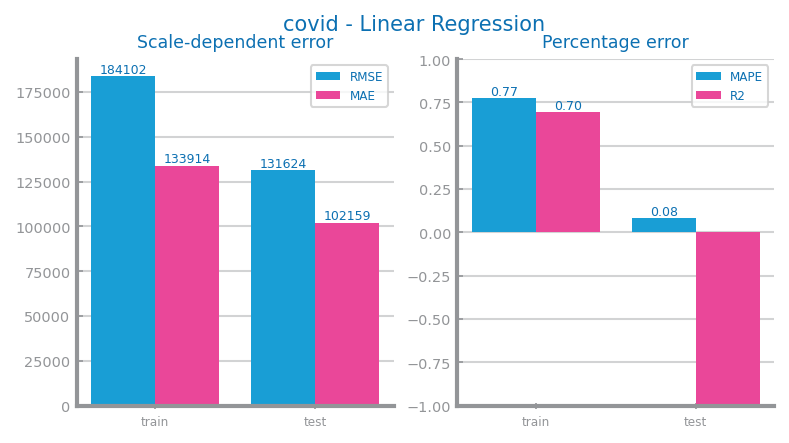

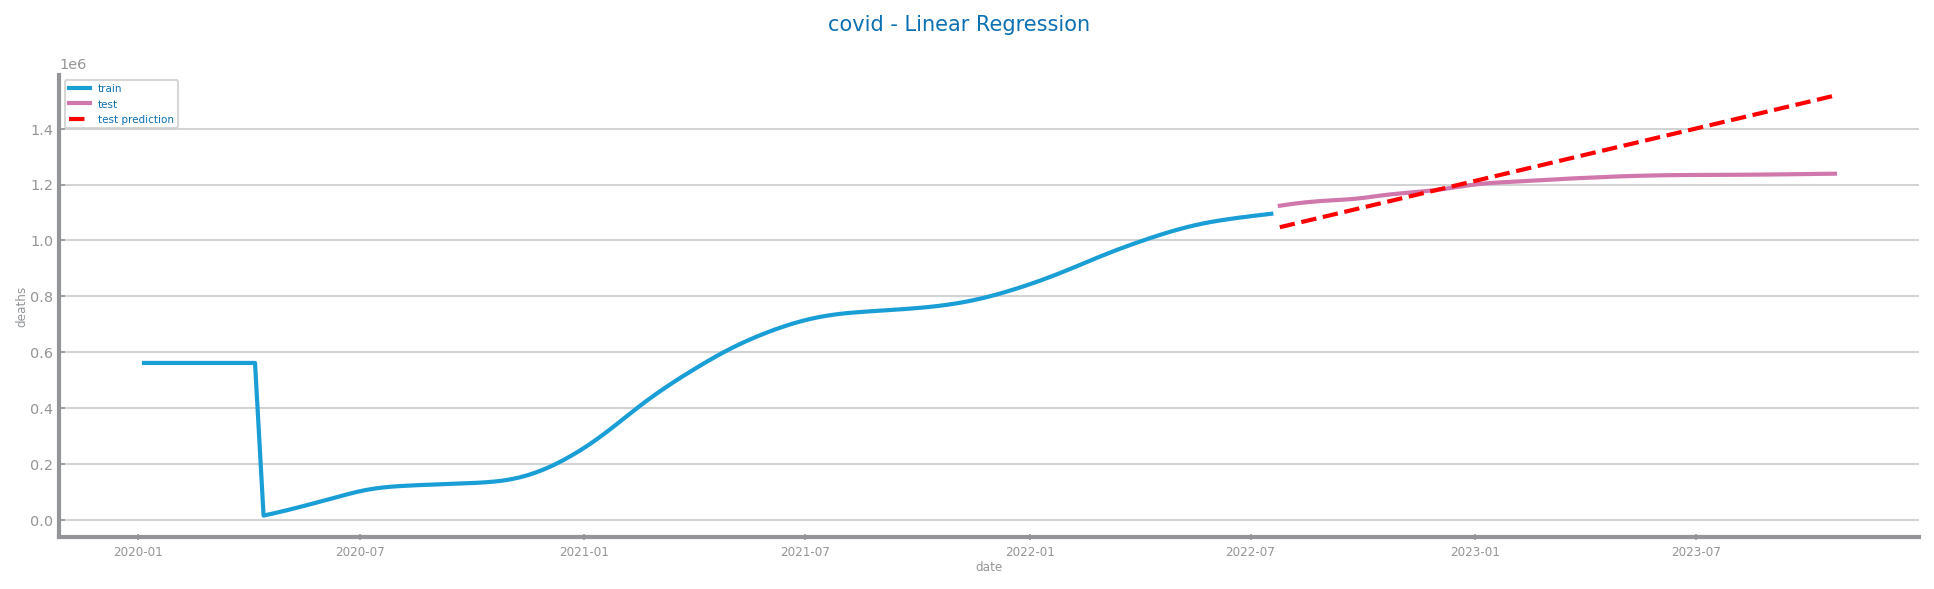

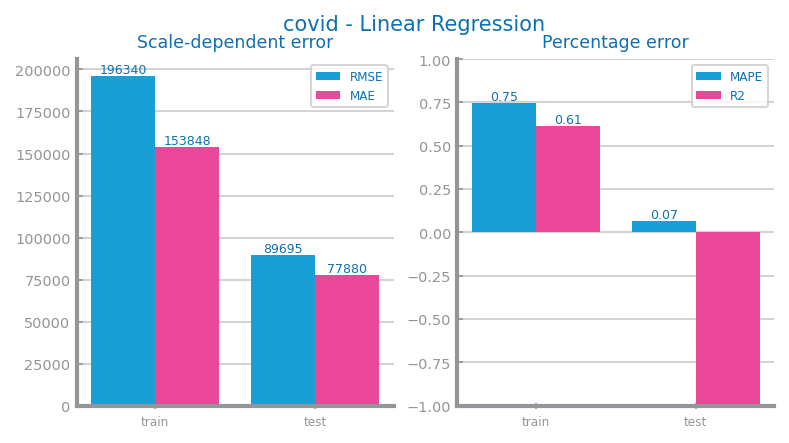

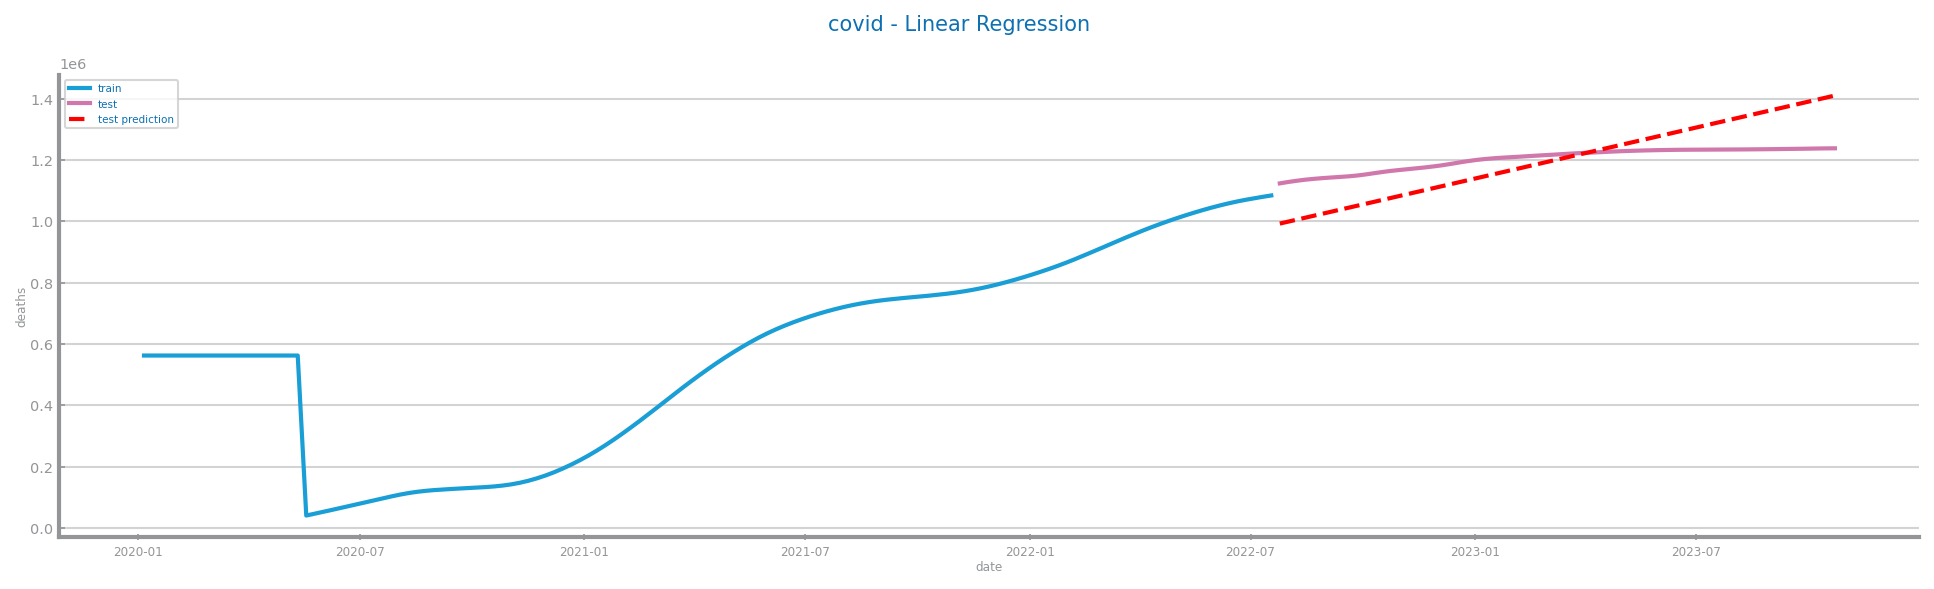

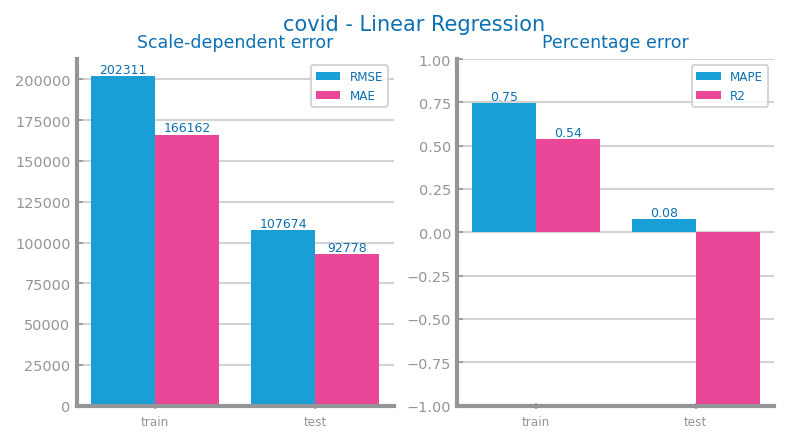

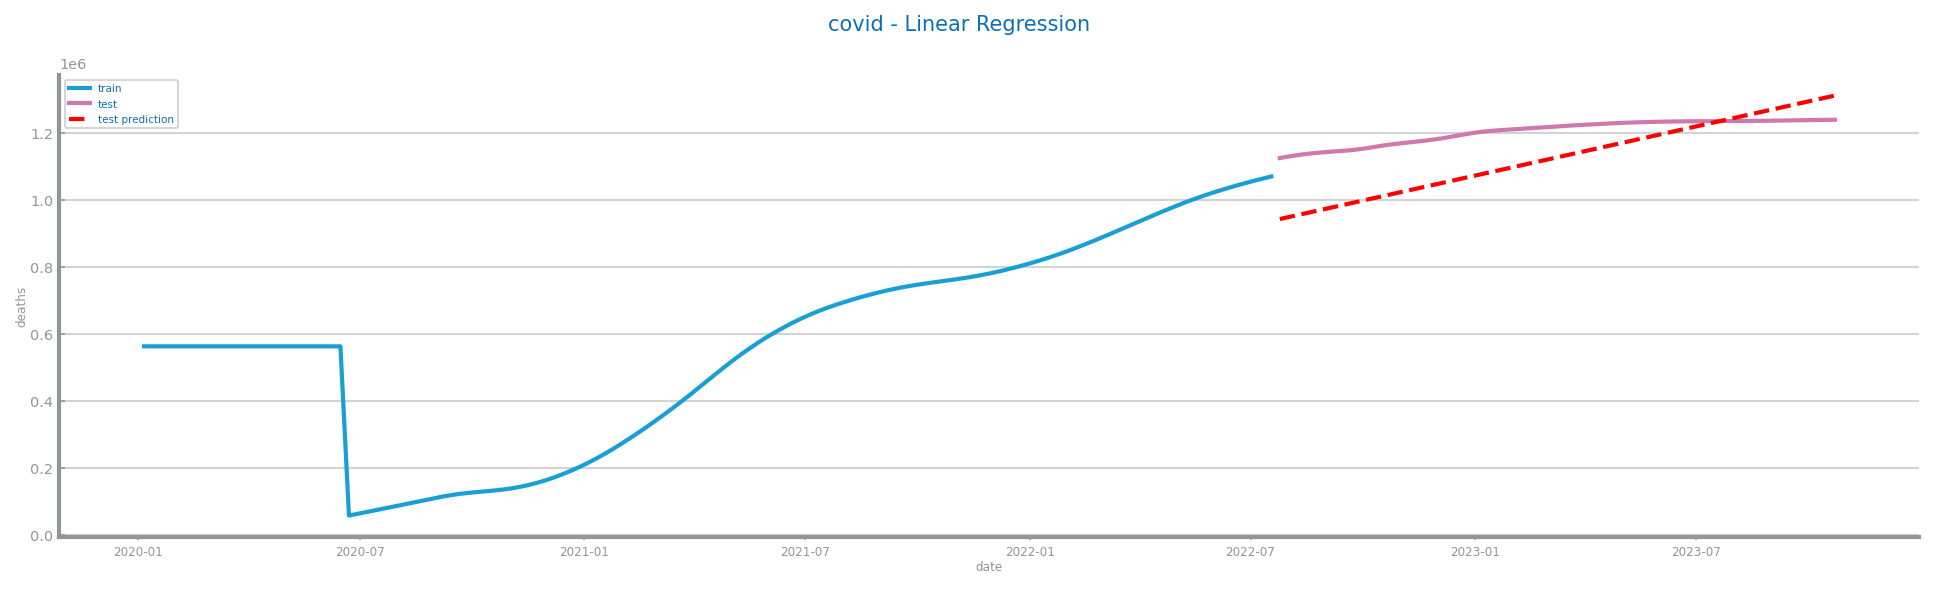

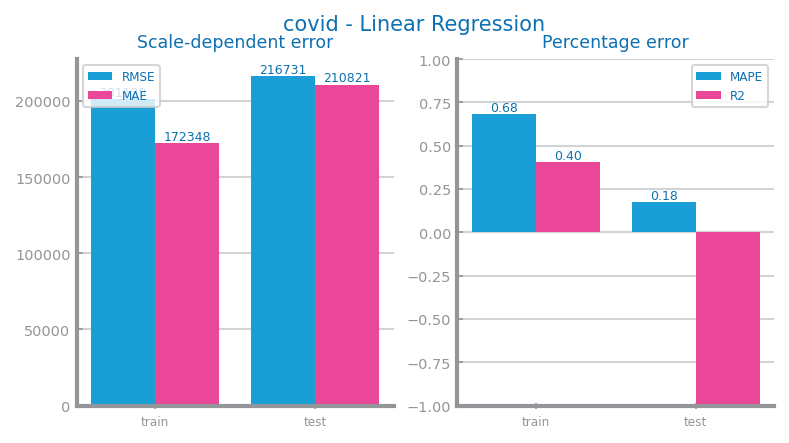

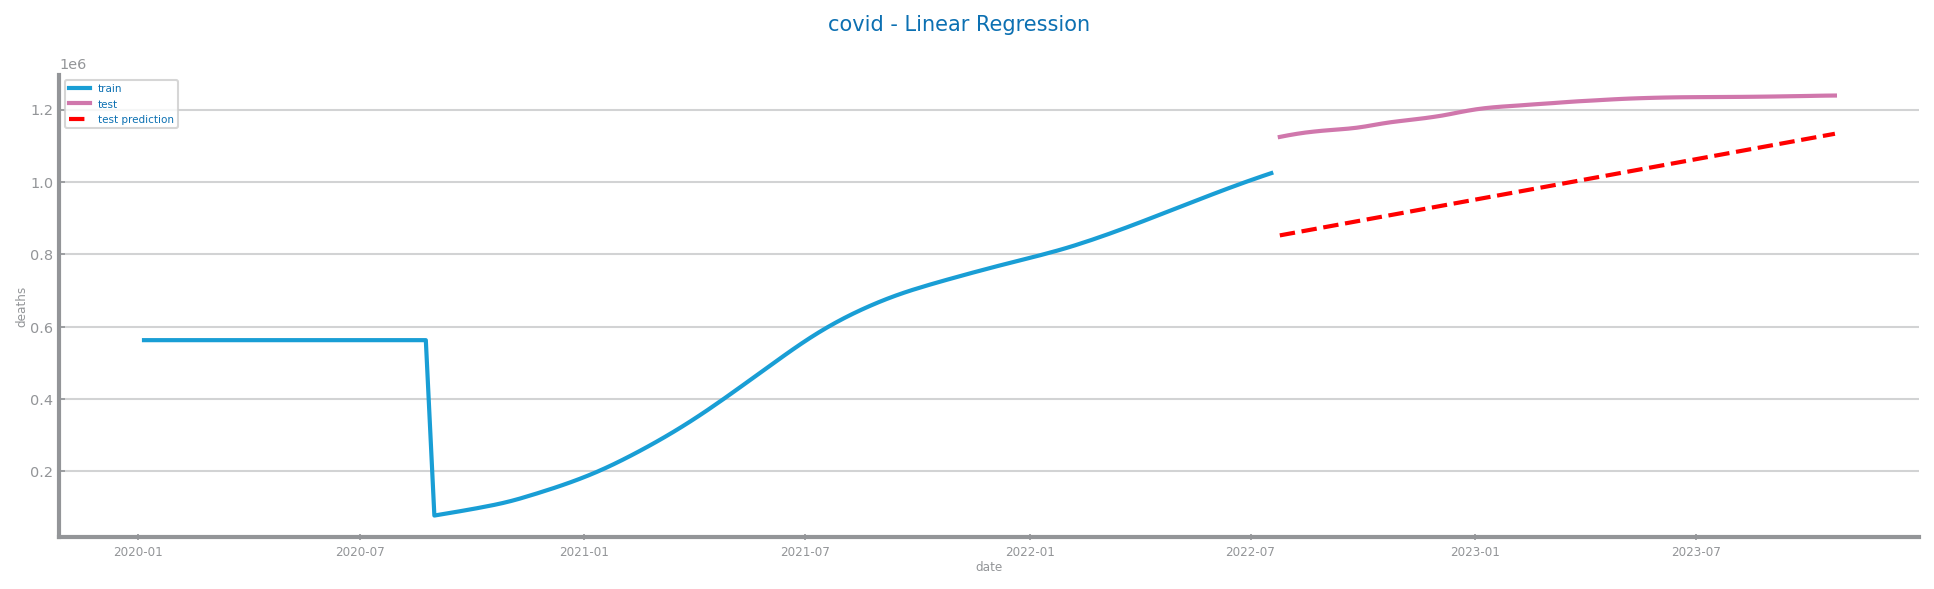

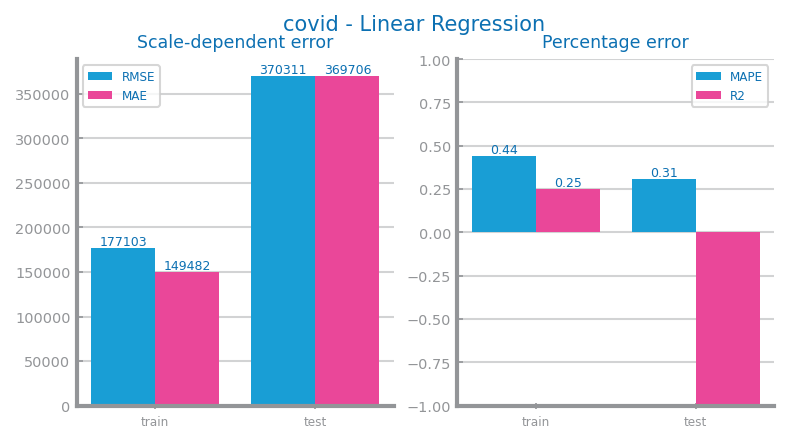

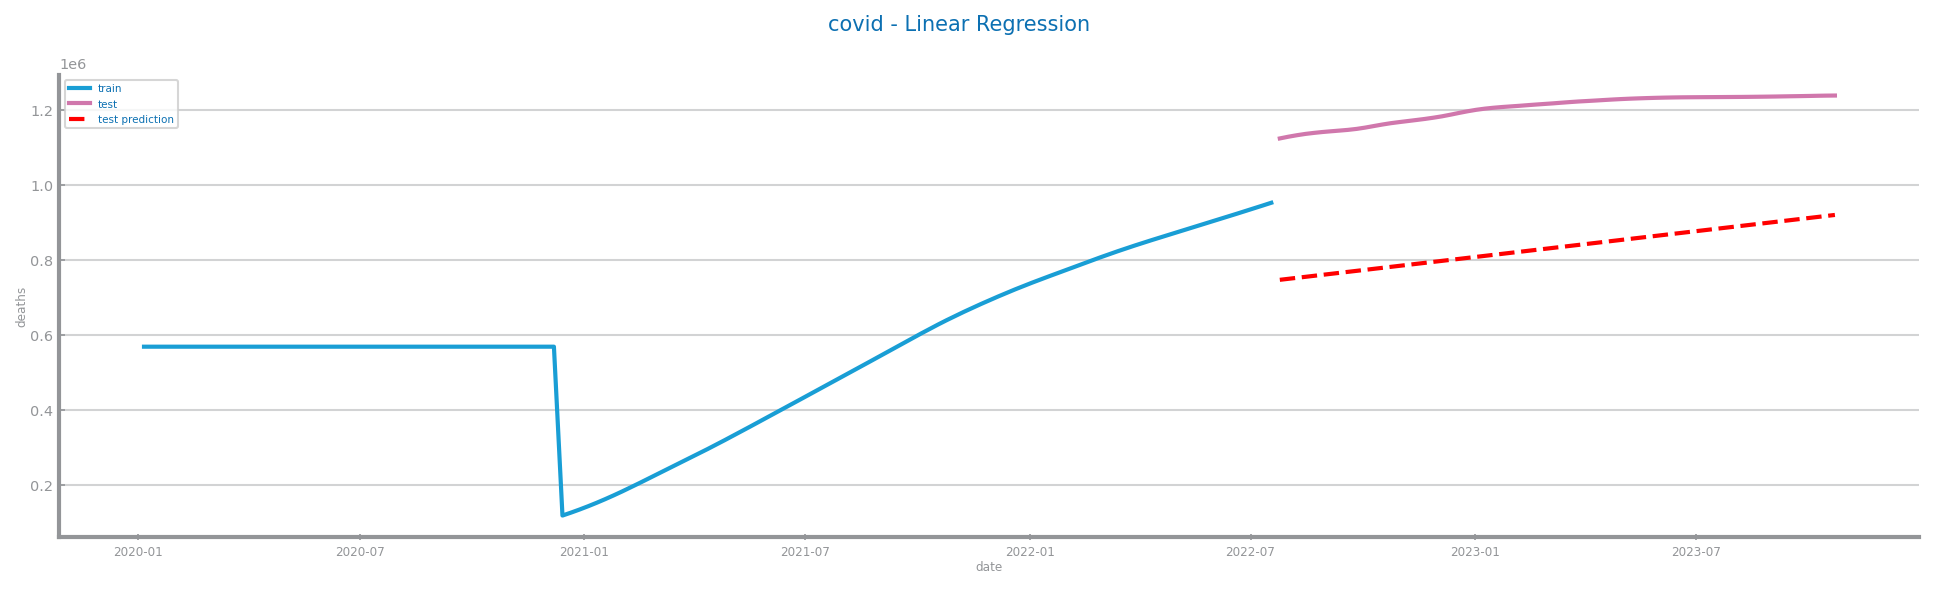

In [43]:
from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from dslabs_functions import dataframe_temporal_train_test_split
from pandas import concat

sizes: list[int] = [15, 20, 25, 35, 50]
fig: Figure
axs: list[Axes]
fig, axs = subplots(len(sizes), 1, figsize=(3 * HEIGHT, HEIGHT * len(sizes)))
fig.suptitle(f"{file_tag} {target} after smoothing")

for i in range(len(sizes)):
    train, test = dataframe_temporal_train_test_split(series, trn_pct=0.67)
    train : Series = train.rolling(window=sizes[i]).mean()
    
    plot_line_chart(
        train.index.to_list(),
        train.to_list(),
        ax=axs[i],
        xlabel=train.index.name,
        ylabel=target,
        title=f"size={sizes[i]}",
    )

    train = train.fillna(train.mean())
    test = test.fillna(test.mean())

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(train)+len(test)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    plot_forecasting_eval(
        train, 
        test, 
        prd_trn, 
        prd_tst, 
        title=f"{file_tag} - Linear Regression"
    )
    savefig(f"images/{file_tag}/smoothing/{sizes[i]}_linear_regression_eval.png")

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"images/{file_tag}/smoothing/{sizes[i]}_linear_regression_forecast.png")
show()

### we conclude that 20 is the best window size

In [56]:
WIN_SIZE = 20
ss_smooth: Series = series.rolling(window=WIN_SIZE).mean()
ss_smooth.to_csv(f"data/{file_tag}/smoothing/smooth.csv")

# DIFFERENTIATION

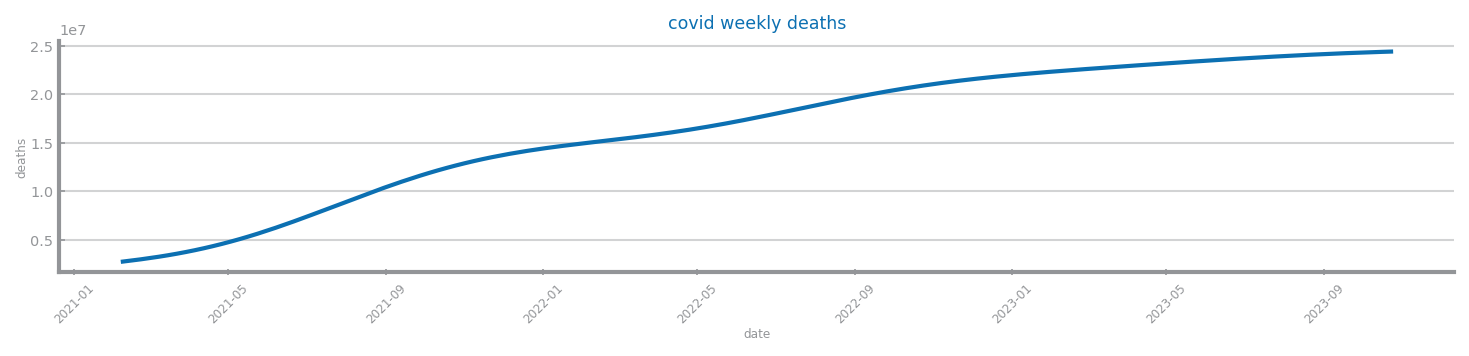

In [57]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_line_chart, HEIGHT

filename: str = f"data/{file_tag}/smoothing/smooth.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} weekly {target}",
)
show()

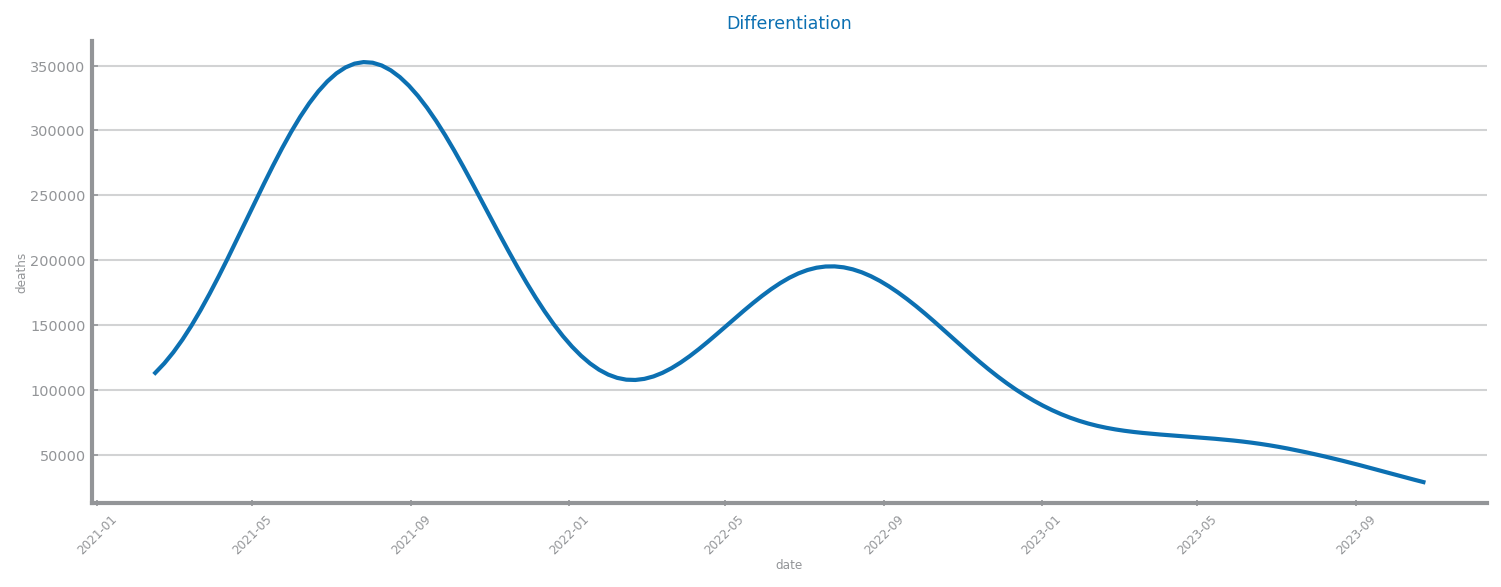

In [58]:
from dslabs_functions import plot_line_chart

ss_diff: Series = series.diff()
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
show()

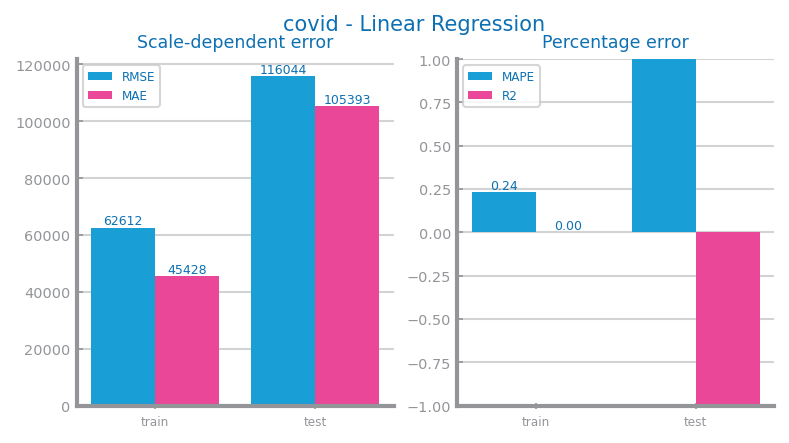

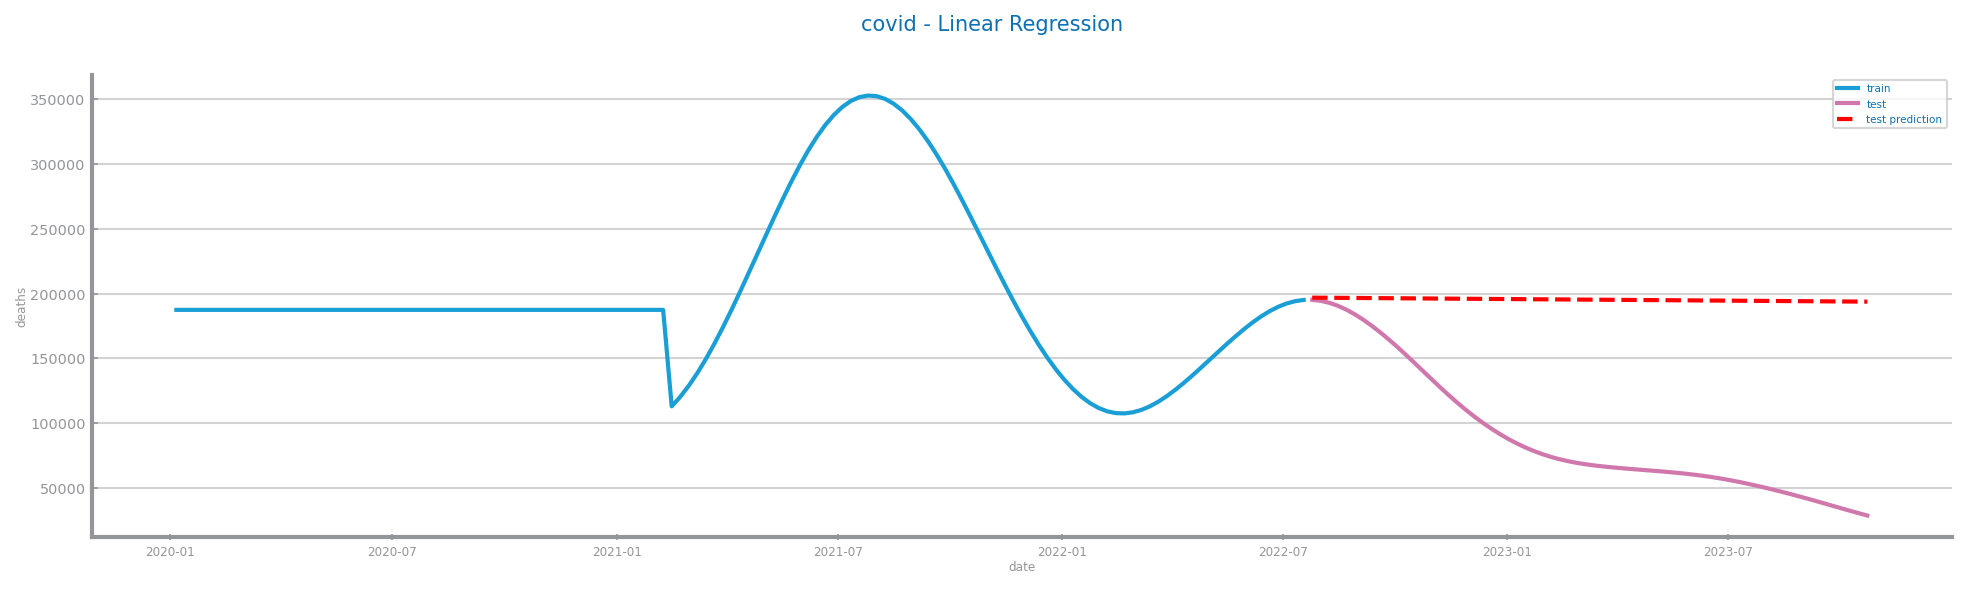

In [59]:
from dslabs_functions import dataframe_temporal_train_test_split
#USER OTHER FUNCTION INSTEAD OF SAVING CSV

train, test = dataframe_temporal_train_test_split(ss_diff, trn_pct=0.67)

# MAYBE USE OTHER METHOD TO FILL NAN
if train.isnull().any() or test.isnull().any():
    train = train.fillna(train.median())
    test = test.fillna(test.median())

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/differentiation/first_diff_linear_regression_eval.png")

plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
savefig(f"images/{file_tag}/differentiation/first_diff_linear_regression_forecast.png")

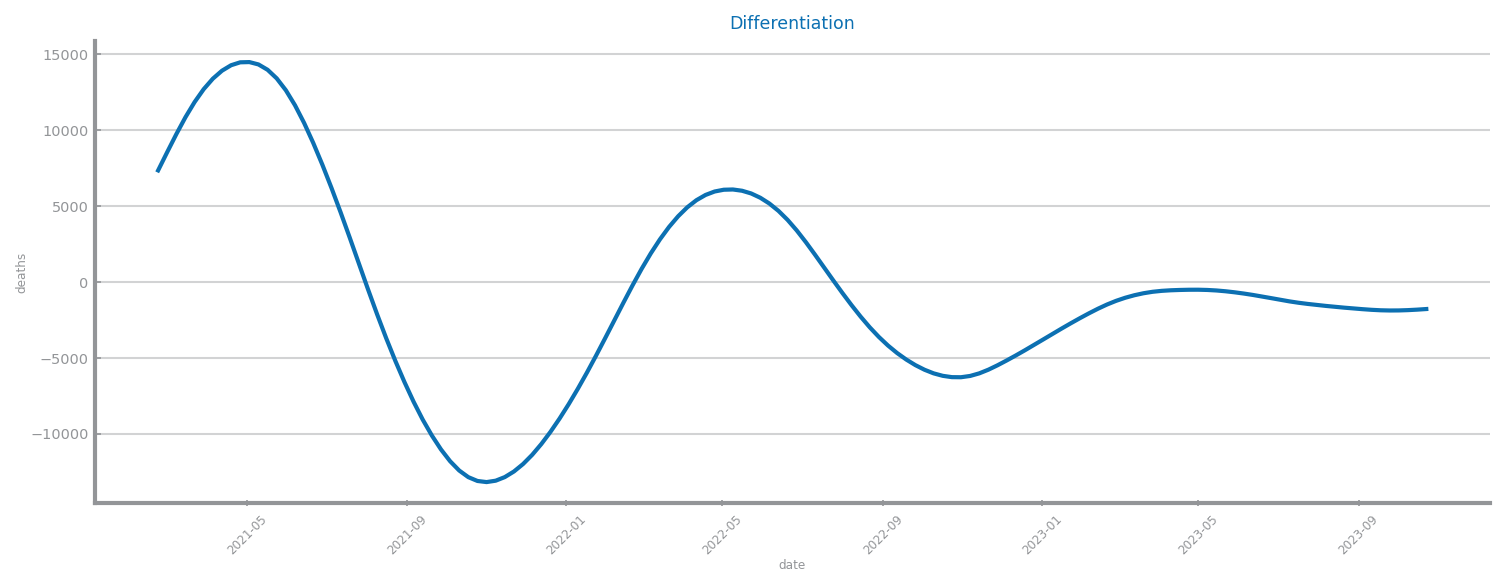

In [60]:
from dslabs_functions import plot_line_chart

ss_diff: Series = ss_diff.diff()
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
show()

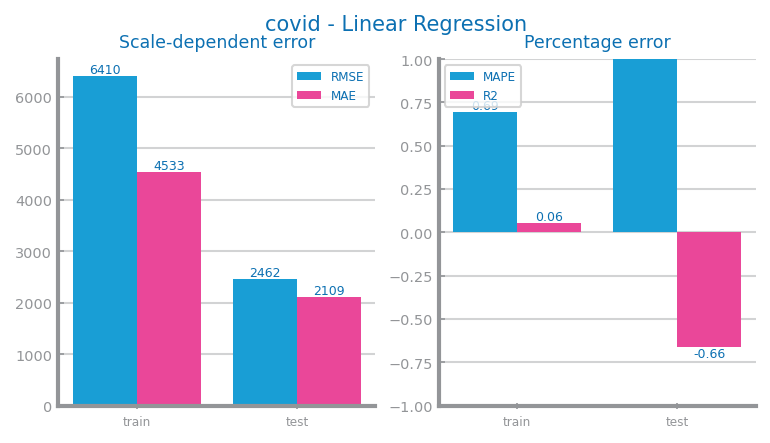

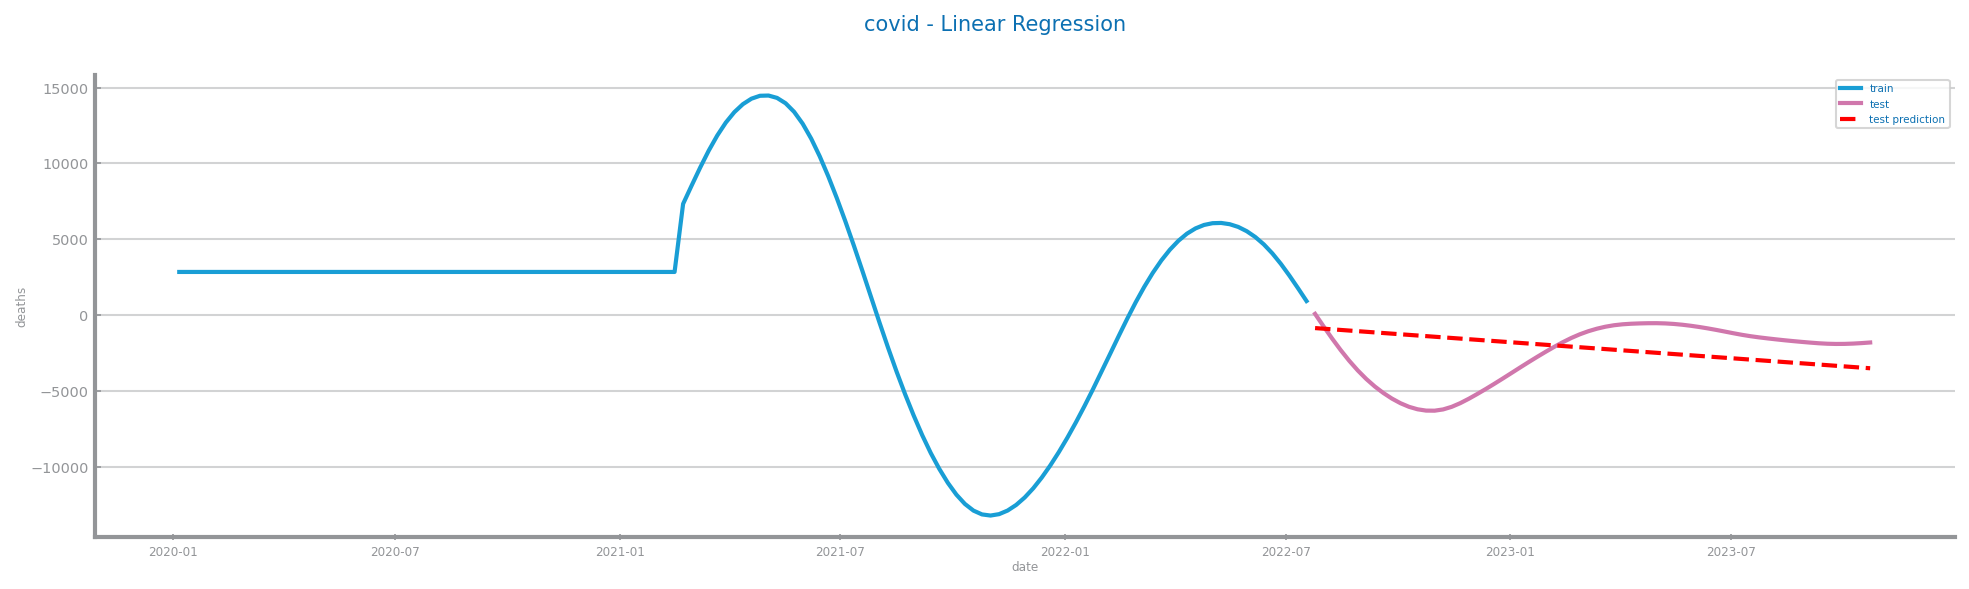

In [61]:
train, test = dataframe_temporal_train_test_split(ss_diff, trn_pct=0.67)

# MAYBE USE OTHER METHOD TO FILL NAN
if train.isnull().any() or test.isnull().any():
    train = train.fillna(train.median())
    test = test.fillna(test.median())

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(ss_diff)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}/differentiation/second_diff_linear_regression_eval.png")

plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Linear Regression",
        xlabel=timecol,
        ylabel=target,
    )
savefig(f"images/{file_tag}/differentiation/second_diff_linear_regression_forecast.png")

### we conclude that no differentiation is better

In [25]:
#ss_diff.to_csv(f"data/{file_tag}/differentiation/{file_tag}_final.csv")

# Model's Evaluation

In [62]:
from pandas import Series
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots, savefig
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_PAST_COLOR, PRED_FUTURE_COLOR, HEIGHT
from math import sqrt
from dslabs_functions import plot_multibar_chart, FORECAST_MEASURES


def series_train_test_split(data: Series, trn_pct: float = 0.90) -> tuple[Series, Series]:
    trn_size: int = int(len(data) * trn_pct)
    df_cp: Series = data.copy()
    train: Series = df_cp.iloc[:trn_size, :]
    test: Series = df_cp.iloc[trn_size:]
    return train, test

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)
    return axs

### Simple Average Model

In [63]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

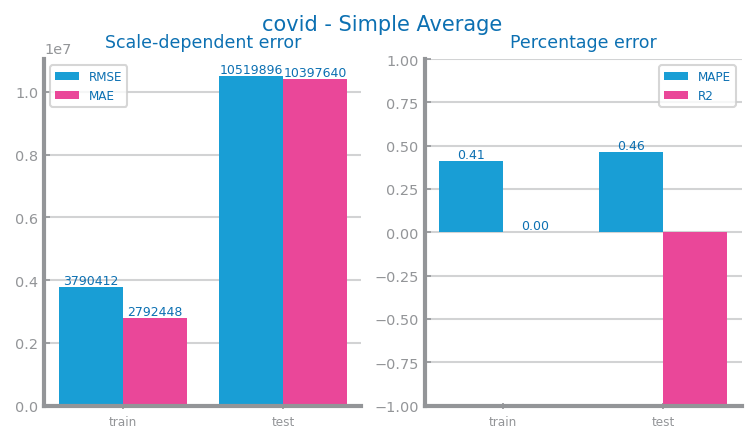

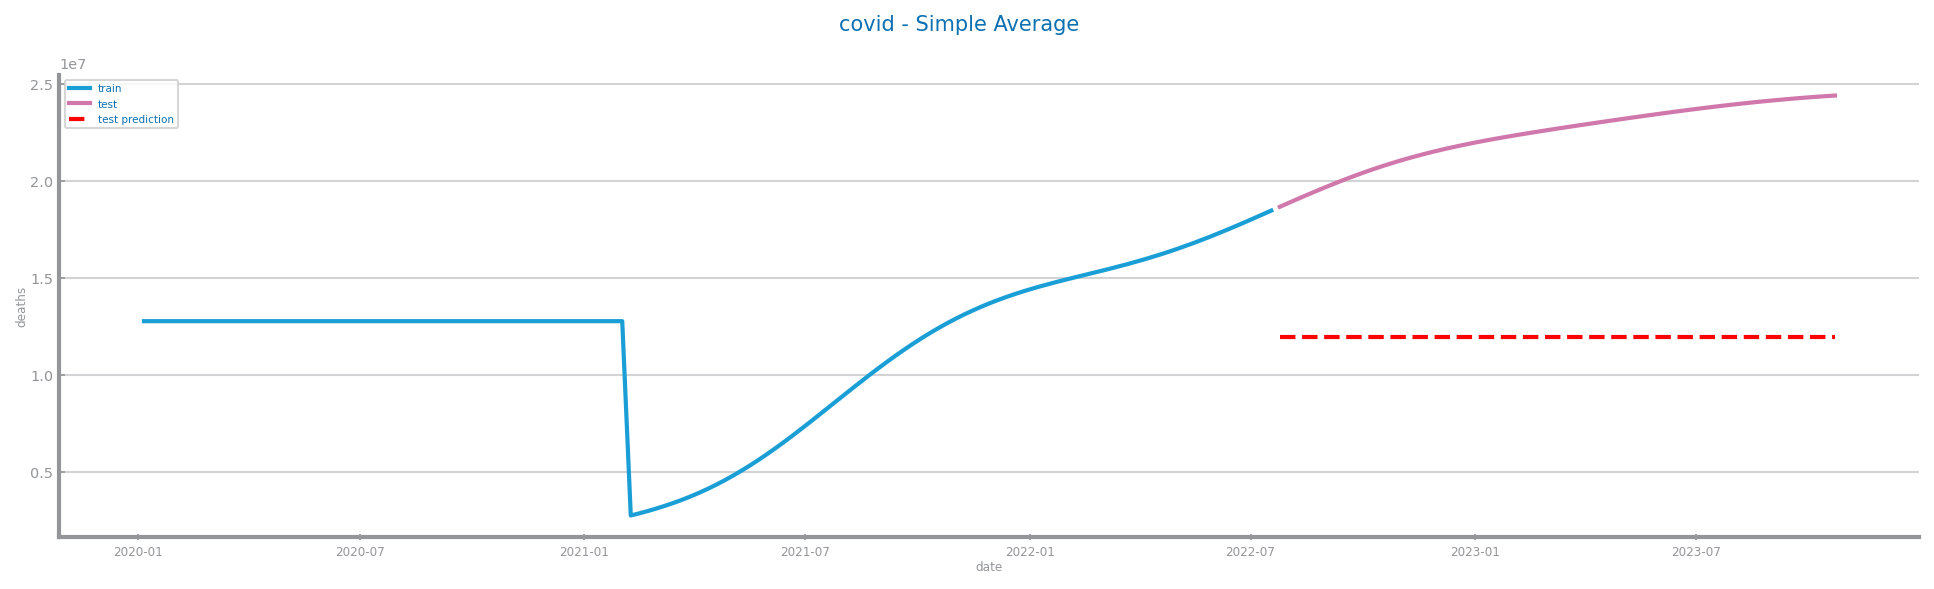

In [64]:
from pandas import read_csv, DataFrame, Series

filetag = 'covid'
filename: str = f"data/{file_tag}/smoothing/smooth.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = series_train_test_split(data, trn_pct=0.67)

train = train.fillna(train.median())
test = test.fillna(test.median())

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Simple Average")
savefig(f"images/{file_tag}/evaluation/simpleAvg_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Simple Average",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/simpleAvg_forecast.png")

### Persistence Model

In [65]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

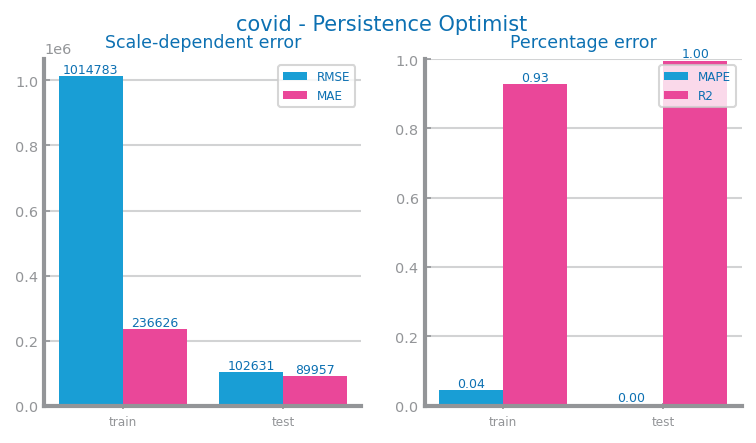

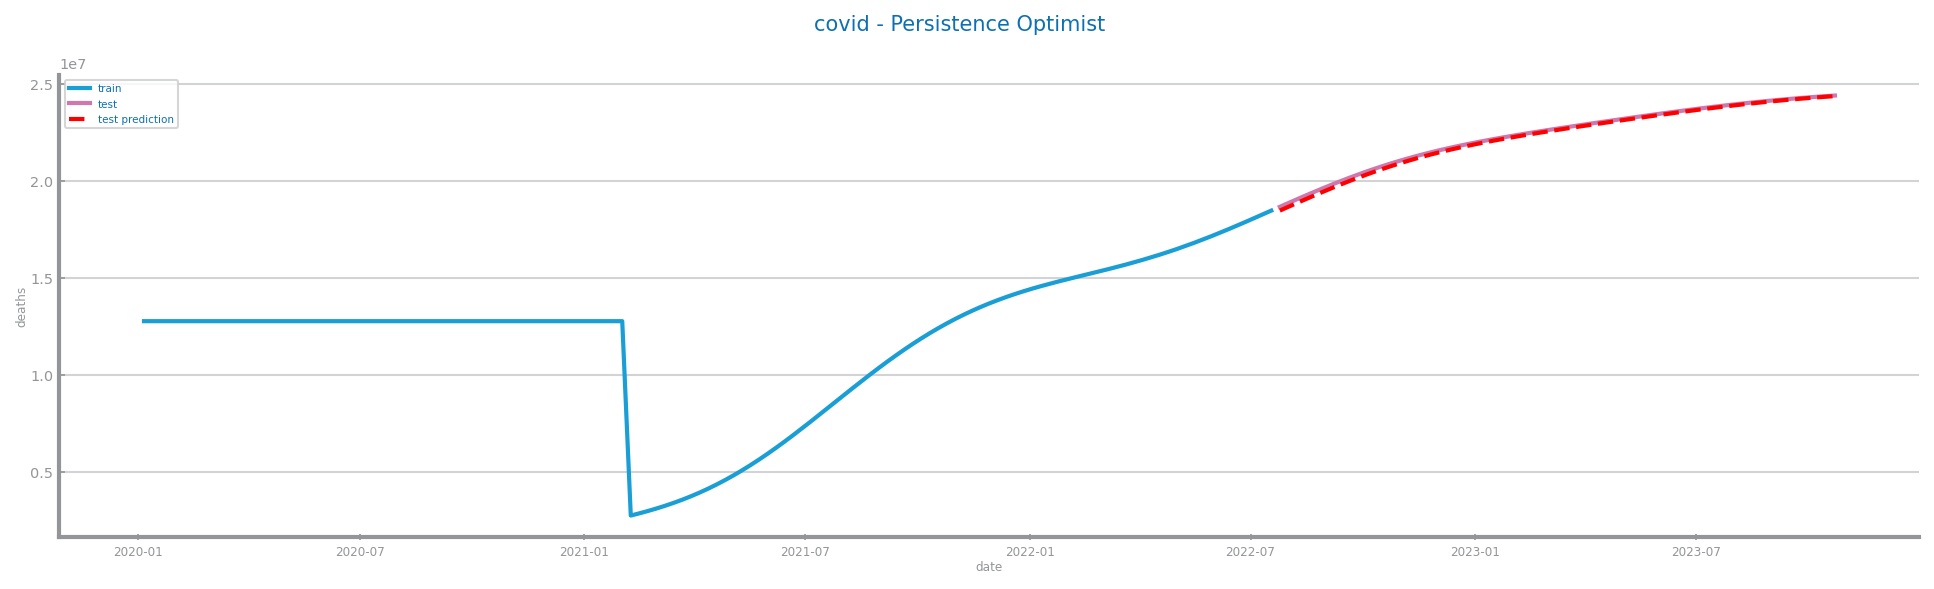

In [66]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series

filename: str = f"data/{file_tag}/smoothing/smooth.csv"
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

train, test = dataframe_temporal_train_test_split(data, trn_pct=0.67)

train = train.fillna(train.median())
test = test.fillna(test.median())

fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist")
savefig(f"images/{file_tag}/evaluation/persistence_optim_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/persistence_optim_forecast.png")

In [67]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

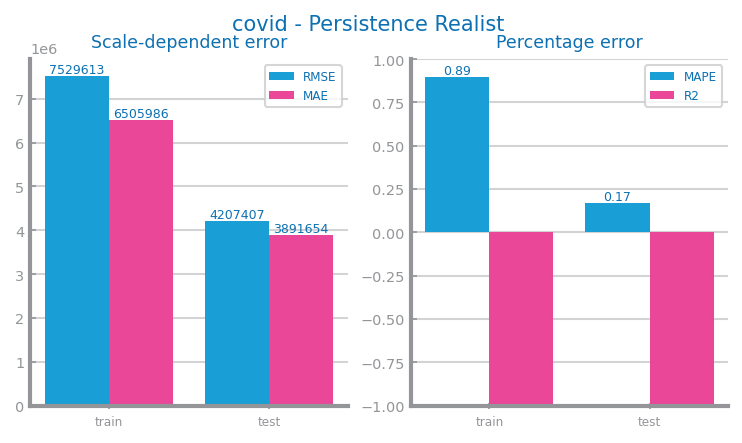

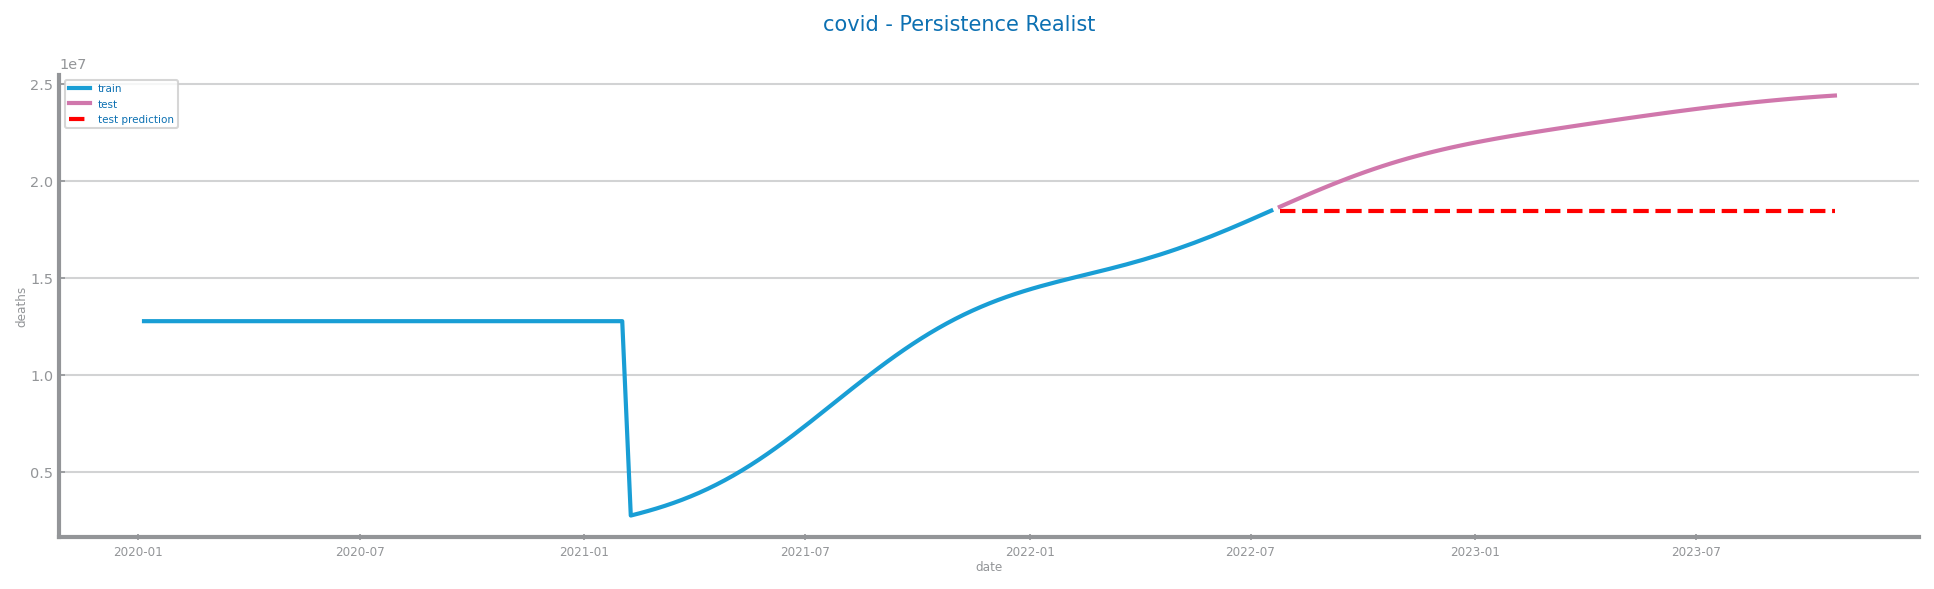

In [68]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist")
savefig(f"images/{file_tag}/evaluation/persistence_real_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/persistence_real_forecast.png")

### Rolling Mean Model

In [76]:
import numpy as np
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin


class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: Series = Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series

In [86]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    #win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )
    savefig(f"images/{file_tag}/evaluation/rollingmean_{measure}_study.png")
    
    return best_model, best_params


3 0.1782820649658631
5 0.1869452030603067
10 0.207741776141639
15 0.22672130425588244
20 0.2436309245523268
25 0.2588192769125407
30 0.2732189129060678
40 0.3047655418835105
50 0.34681095157777436
Rolling Mean best with win=50 -> MAPE=0.34681095157777436


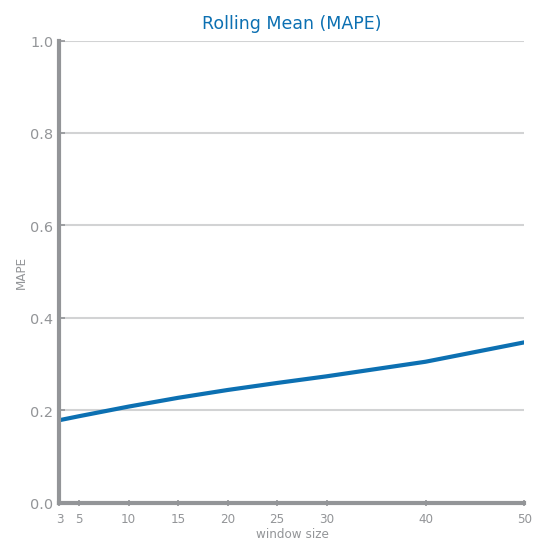

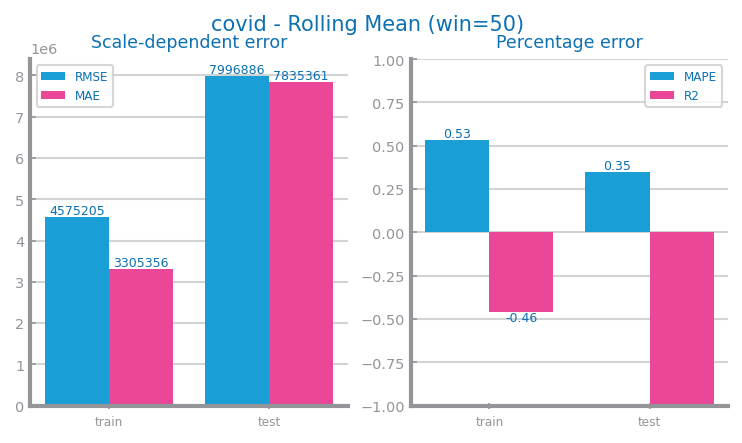

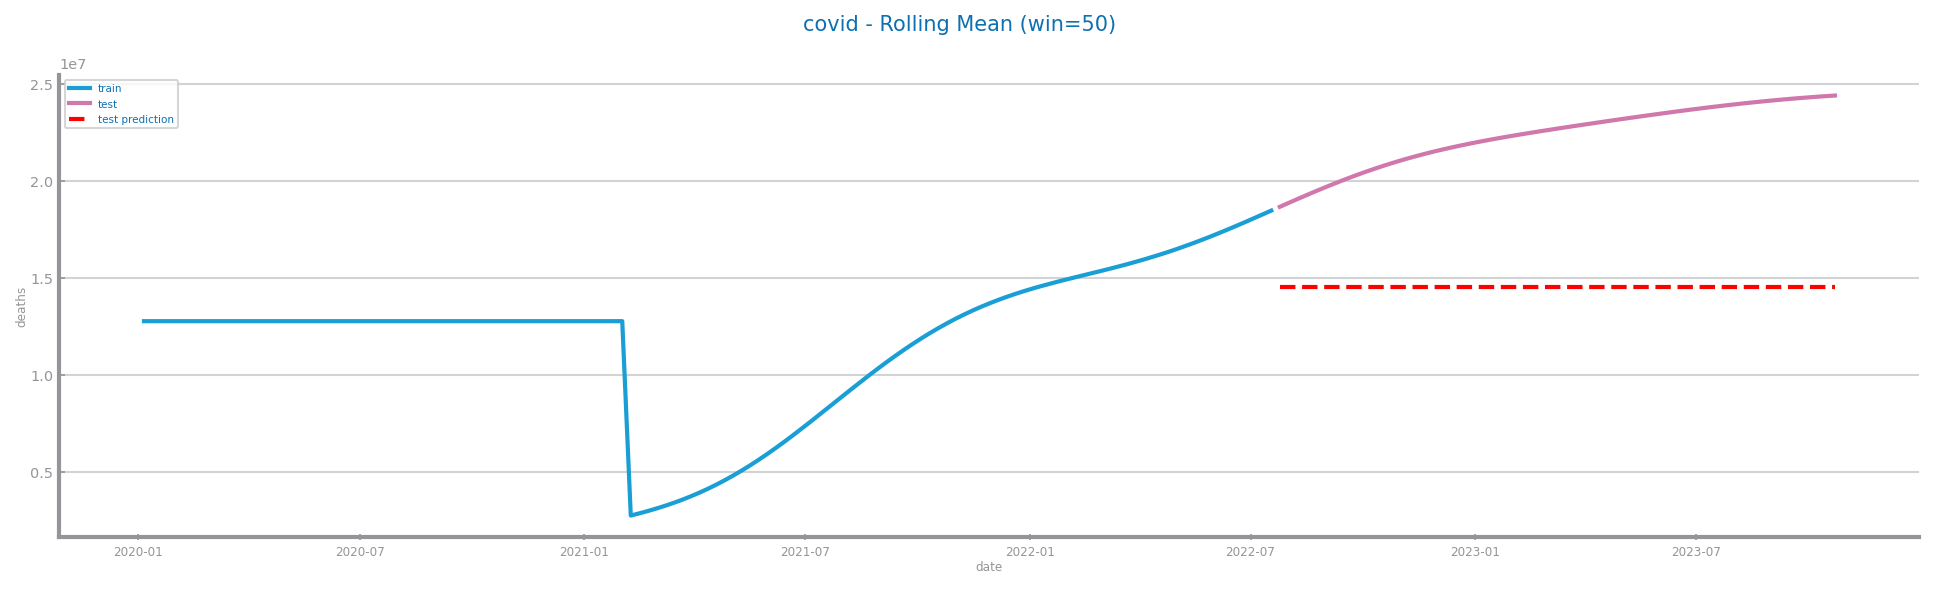

In [97]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series, HEIGHT

measure: str = "MAPE"

train, test = series_train_test_split(data, trn_pct=0.67)

train = train.fillna(train.median())
test = test.fillna(test.median())

fig = figure(figsize=(HEIGHT, HEIGHT))
best_model, best_params = rolling_mean_study(train, test, measure)

params = best_params["params"]
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"images/{file_tag}/evaluation/rollingmean_{measure}_win{params[0]}_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/rollingmean_{measure}_forecast.png")


### ARIMA Model

In [123]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

measure: str = "R2"

train, test = series_train_test_split(data, trn_pct=0.67)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 deaths   No. Observations:                  133
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -363.443
Date:                Fri, 29 Dec 2023   AIC                            738.887
Time:                        16:33:22   BIC                            756.183
Sample:                    01-06-2020   HQIC                           745.915
                         - 07-18-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.9831      0.013    224.190      0.000       2.957       3.009
ar.L2         -2.9780      0.027   -112.098      0.000      -3.030      -2.926
ar.L3          0.9950      0.013     74.744      0.0

c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


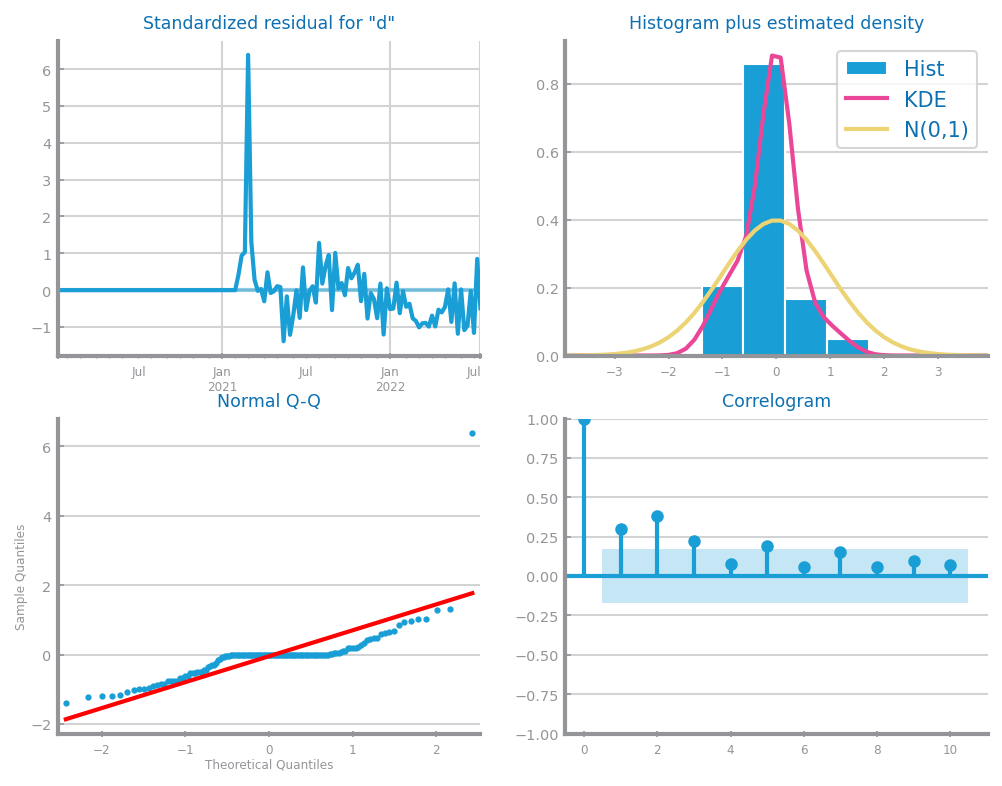

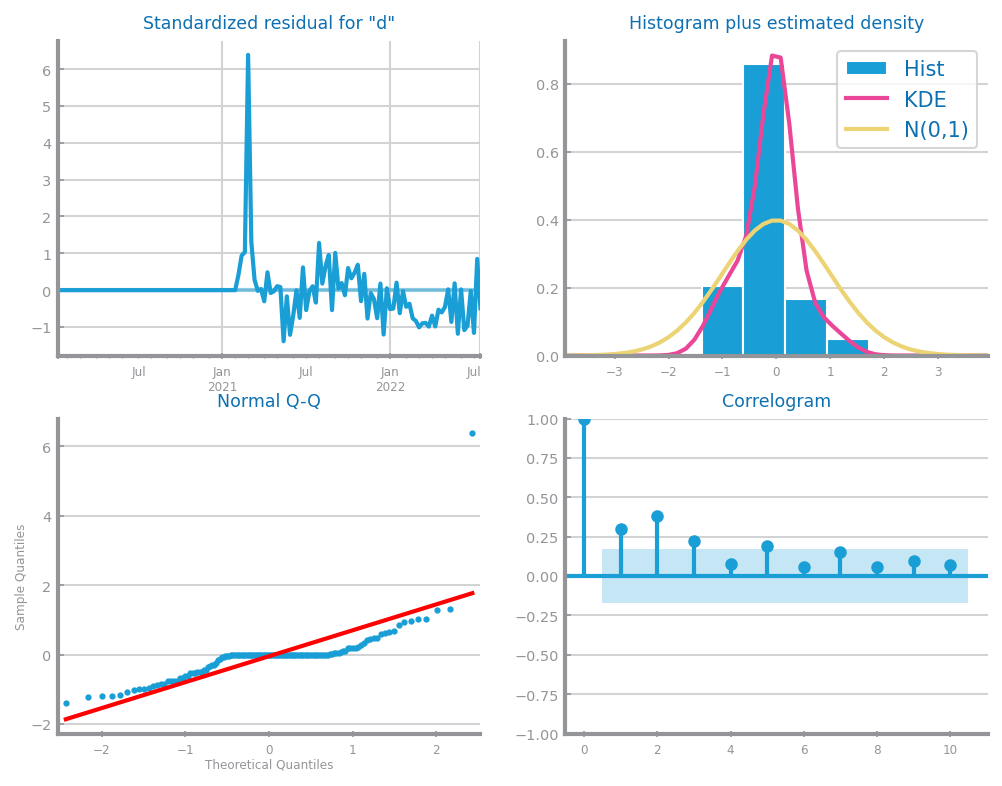

In [124]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [127]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                if d == 2 and p > 5:
                    yvalues.append(1)
                    yvalues.append(1)
                    break
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                #print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo

alo


c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo

alo


c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


alo


c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Eduardo Lobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


alo
ARIMA best results achieved with (p,d,q)=(10, 1, 3) ==> measure=0.96


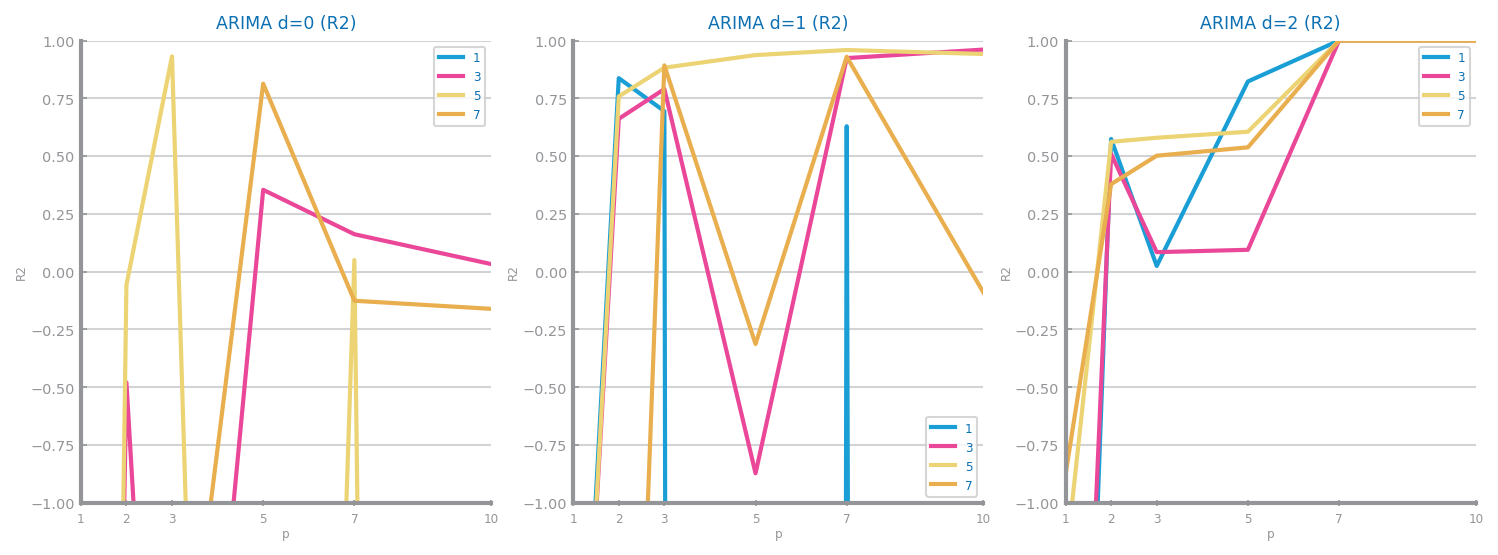

In [126]:
from matplotlib.pyplot import savefig

# Increase the order of differencing (d) parameter in the ARIMA model
best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/{file_tag}/evaluation/arima_{measure}_study.png")

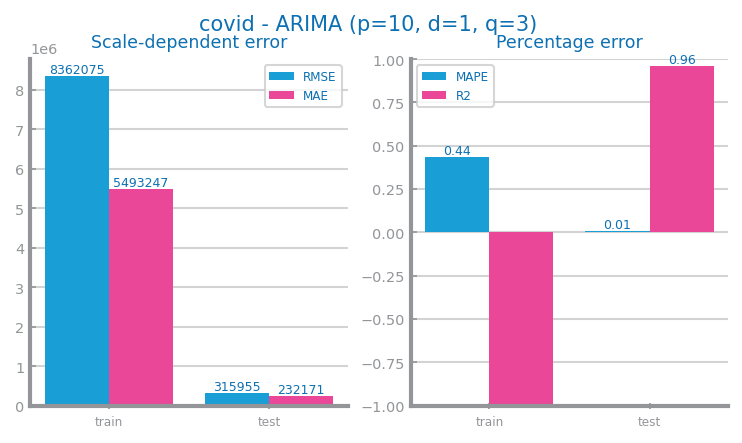

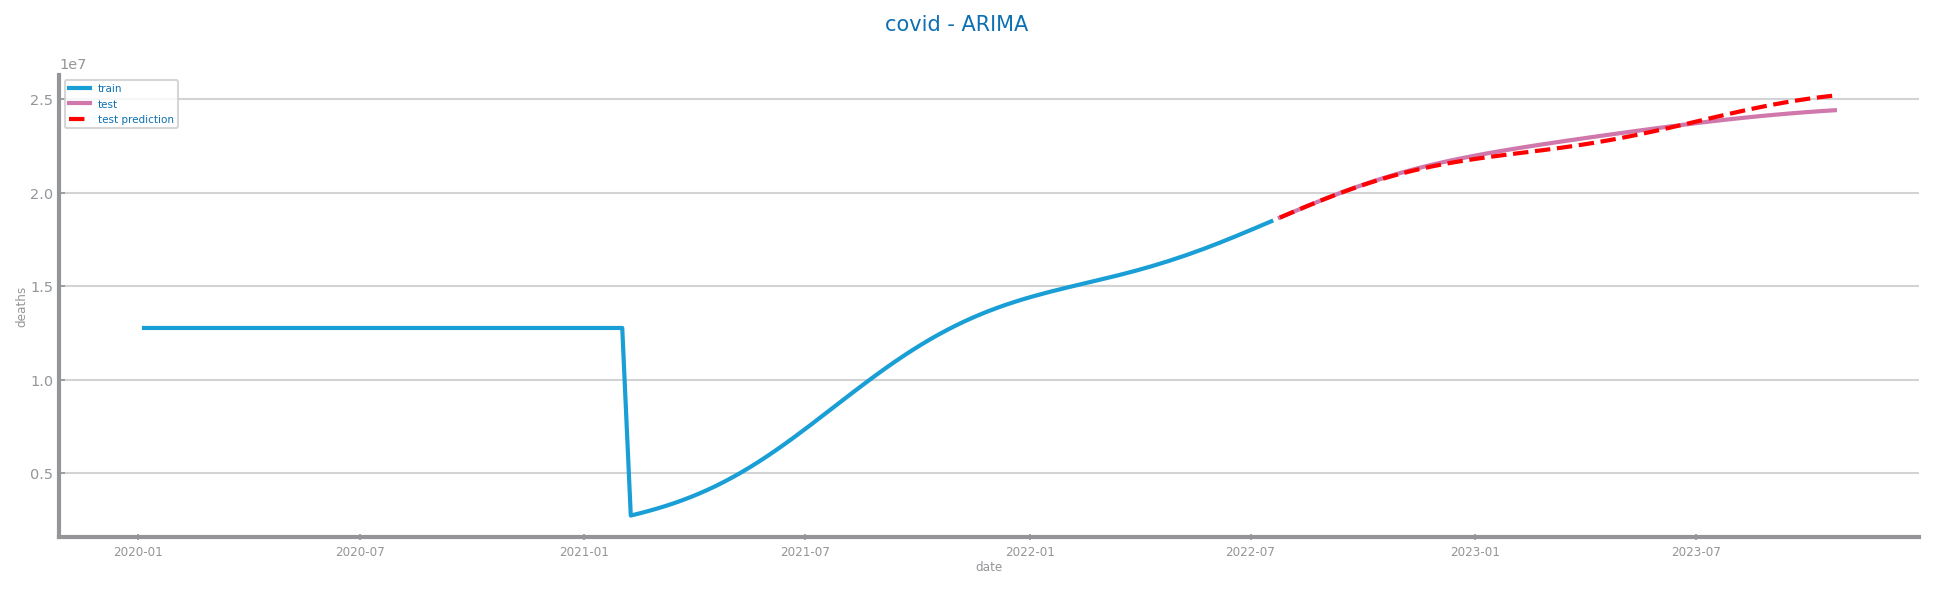

In [128]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

train = train.fillna(train.median())
test = test.fillna(test.median())

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}/evaluation/arima_{measure}_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/arima_{measure}_forecast.png")

### LSTMs Model

In [ ]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [ ]:
from pandas import read_csv, DataFrame, Series
from dslabs_functions import series_train_test_split

measure: str = "R2"

series = data[[target]].values.astype("float32")

train_size = int(len(series) * 0.90)
train, test = series[:train_size], series[train_size:]

In [ ]:
model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

In [ ]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


best_model, best_params = lstm_study(train, test, nr_episodes=3000, measure=measure)

In [ ]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)
savefig(f"images/{file_tag}/evaluation/lstms_{measure}_eval.png")

series = data[[target]]
train, test = series[:train_size], series[train_size:]
pred_series: Series = Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}/evaluation/lstms_{measure}_forecast.png")